In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, RBF
from output import format_for_submission
import csv

In [2]:
random.seed(51)

def get_function_data(function_number):
    ary_in = np.load(f'../data/raw/initial_data/function_{function_number}/initial_inputs.npy')
    ary_out = np.load(f'../data/raw/initial_data/function_{function_number}/initial_outputs.npy')

    week1_out = [0.0, -0.03634716524130564, -0.13995571712281177, -11.512791229057324, 351.7115420928652, -0.5971511450896173, 0.2910786825809617, 8.618272750952901]
    week1_in = [np.array([0.00367, 0.9999 ]), 
                np.array([0.851999, 0.973204]), 
                np.array([0.747032, 0.28413 , 0.226329]), 
                np.array([0.169128, 0.756136, 0.275457, 0.528761]), 
                np.array([0.439601, 0.772709, 0.376277, 0.933269]), 
                np.array([0.232204, 0.132714, 0.53824 , 0.760706, 0.075595]), 
                np.array([0.476821, 0.248196, 0.242816, 0.576157, 0.162416, 0.290926]), 
                np.array([0.221603, 0.703755, 0.674607, 0.130295, 0.376739, 0.669444, 0.136655, 0.061316])]    
    
    week2_out = [-1.2075460499722905e-18, 0.17608630702211278, -0.17239781799687137, -31.982880235497266, 1236.8846557000643, -2.451406055102475, 0.00010805707939840242, 5.178959940699899]
    week2_in = [np.array([0.476035, 0.572563]), 
                np.array([0.641846, 0.498841]), 
                np.array([0., 0., 0.]), 
                np.array([0.953433, 0.895217, 0.812477, 0.618719]), 
                np.array([0.987523, 0.470227, 0.946409, 0.105412]), 
                np.array([3.40696e-01, 4.94179e-01, 2.10000e-05, 3.08050e-02, 9.39958e-01]), 
                np.array([0.88314 , 0.756642, 0.      , 0.      , 0.9     , 0.942719]), 
                np.array([0.993634, 0.968223, 0.979285, 0.397318, 0.965856, 0.955218, 0.006078, 0.024001])]

    ary_out=np.append(ary_out, week1_out[function_number-1])
    ary_out=np.append(ary_out, week2_out[function_number-1])
    ary_in=np.vstack((ary_in, week1_in[function_number-1]))
    ary_in=np.vstack((ary_in, week2_in[function_number-1]))
    
    return ary_in, ary_out

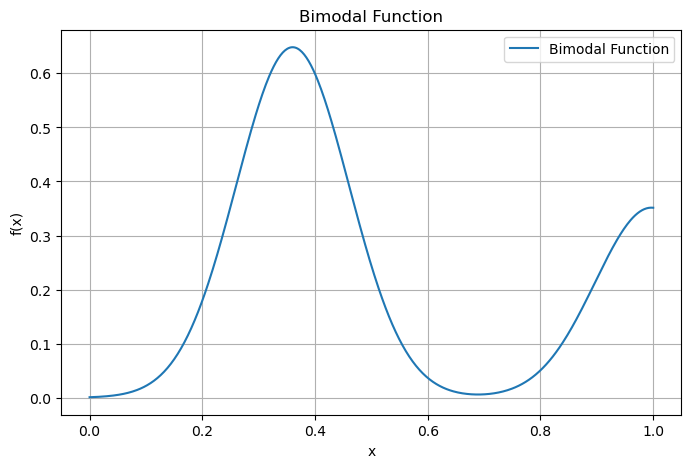

Max from grid search: 0.6483588866639842


In [8]:
#Test bimodal function
class one_d_test:
    # Parameters for the two Gaussian peaks
    #mu1 is x of first peak
    #mu2 is x of second peak TODO: experiment with 0.02-0.2
    #Sigmas are widths of peaks
    #alpha1 is weight of first peak (default 1)
    #alpha2 is weight of second peak (default 0.5)

    sigma1 = 0.1
    sigma2 = 0.1
    mu1 = 0.3
    mu2 = 0.7
    alpha1 = 1
    alpha2 = 0.5

    def __init__(self, sigma1=0.1, sigma2=0.1, mu1=0.3, mu2=0.7, alpha1=1, alpha2=0.5):
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.mu1 = mu1
        self.mu2 = mu2
        self.alpha1 = alpha1
        self.alpha2 = alpha2

    def call_function(self, x): 
        # Calculate the two Gaussian components
        gaussian1 = np.exp(-((x - self.mu1) ** 2) / (2 * self.sigma1 ** 2))
        gaussian2 = np.exp(-((x - self.mu2) ** 2) / (2 * self.sigma2 ** 2))
        gaussian1 = self.alpha1 * gaussian1
        gaussian2 = self.alpha2 * gaussian2
        
        # Combine and normalize to keep the output between 0 and 1
        result = (gaussian1 + gaussian2) / (self.alpha1 + self.alpha2)
        return result

# Test the function with a range of values
x = np.linspace(0, 1, 500)
testmu1 = random.random()
testmu2 = random.random()
testalpha2 = random.uniform(0.3, 0.9)
oned = one_d_test(mu1=testmu1, mu2=testmu2, alpha2=testalpha2)
y = oned.call_function(x)

# Plot the function
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Bimodal Function")
plt.title("Bimodal Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()


print("Max from grid search:", np.max(y))

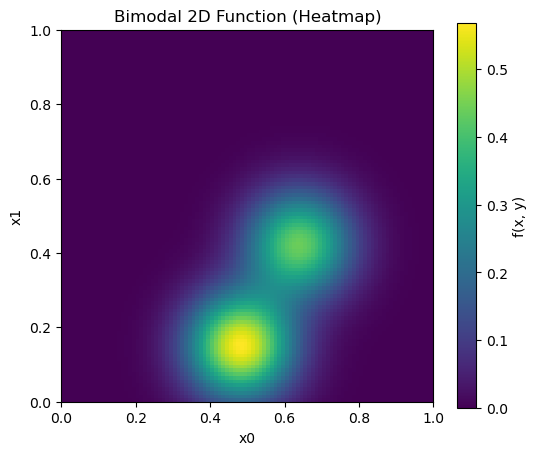

Max from grid search: 0.5671041065151622


In [22]:
class two_d_test:

    def __init__(self, sigma1=0.1, sigma2=0.1, mu1=[0.3,0.3], mu2=[0.7,0.7], alpha1=1, alpha2=0.5):
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.mu1 = mu1
        self.mu2 = mu2
        self.alpha1 = alpha1
        self.alpha2 = alpha2

    sigma1 = 0.1
    sigma2 = 0.1
    mu1 = [0.3,0.3]
    mu2 = [0.7,0.7]
    alpha1 = 1
    alpha2 = 0.5

    def call_function(self, X):
        """
        Bimodal function f(x0, x1) in [0, 1]^2 -> [0, 1].
        X is an array of shape (N, 2).
        Returns a 1D array of length N, each element in [0, 1].
        """

        X = np.asarray(X)
        X = np.atleast_2d(X)  # Ensure X is 2D
        x0 = X[:, 0]  # shape (N,)
        x1 = X[:, 1]  # shape (N,)

        # 2D Gaussian around (mu1[0], mu1[1])
        g1 = np.exp(-(((x0 - self.mu1[0]) ** 2) / (2 * self.sigma1 ** 2)
                      + ((x1 - self.mu1[1]) ** 2) / (2 * self.sigma1 ** 2)))

        # 2D Gaussian around (mu2[0], mu2[1]) 
        g2 = np.exp(-(((x0 - self.mu2[0]) ** 2) / (2 * self.sigma2 ** 2)
                      + ((x1 - self.mu2[1]) ** 2) / (2 * self.sigma2 ** 2)))

        # Combine and normalize so max remains <= 1
        return (self.alpha1 * g1 + self.alpha2 * g2) / (self.alpha1 + self.alpha2)


def plot_twod_objective(twod):

    N = 100
    x0_vals = np.linspace(0, 1, N)
    x1_vals = np.linspace(0, 1, N)
    X0, X1 = np.meshgrid(x0_vals, x1_vals)        # shape (N, N) each
    X_grid = np.column_stack((X0.ravel(), X1.ravel()))  # shape (N*N, 2)

    y_grid  = twod.call_function(X_grid)
    # Reshape back to (N, N) for plotting
    y_2d = y_grid.reshape(N, N)
    
    # Heatmap
    plt.figure(figsize=(6, 5))
    plt.imshow(y_2d, origin='lower', extent=(0,1,0,1), cmap='viridis', aspect='equal')
    plt.colorbar(label='f(x, y)')
    plt.title("Bimodal 2D Function (Heatmap)")
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.show()

    # 3D surface
    #fig = plt.figure(figsize=(8,6))
    #ax = fig.add_subplot(111, projection='3d')
    #ax.plot_surface(X0, X1, y_2d, cmap='viridis', edgecolor='none')
    #ax.set_title("Bimodal 2D Function (Surface Plot)")
    #ax.set_xlabel("x0")
    #ax.set_ylabel("x1")
    #ax.set_zlabel("f(x, y)")
    #plt.show()

    print("Max from grid search:", np.max(y_2d))



testmu1 = [random.random(),random.random()]
testmu2 = [random.random(),random.random()]
testalpha2 = random.uniform(0.3, 0.9)

twod = two_d_test(mu1=testmu1, mu2=testmu2, alpha2=testalpha2)
plot_twod_objective(twod)


In [34]:
# Test acquisition functions on the 1d function

noise_assumption = 1e-10 # noise assumption, a hyper-parameter

input_bounds = [(0, 1)] # bounds for the input space

#Experiment with lengthscale 0.1 to 0.5 in steps of 0.05
# and kappa 0.1 to 3 in steps of 0.1

def bounds_midpoint(input_bounds):
    return np.array([(low + high) / 2.0 for low, high in input_bounds])

def acquisition_UCB(x, model, ucb_kappa):
    mean, std = model.predict(x.reshape(1, -1), return_std=True)
    return mean + ucb_kappa * std

def test_on_oned(rbf_lengthscale, ucb_acquisition_kappa, test_oned_function, max_iterations):
    
    objective_x = np.linspace(0, 1, 500)
    objective_y = test_oned_function.call_function(objective_x)
    objective_y_max = max(objective_y)

    #quick plot objective function
    #plt.figure(figsize=(3, 5))
    #plt.plot(objective_x, objective_y, label="Objective")
    #plt.grid(True)
    #plt.legend()
    #plt.show()

    kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')
    model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)

    X = []
    Y = []
    # First point
    x0 = bounds_midpoint(input_bounds)  # array([0.5])
    X.append(x0)
    Y.append(test_oned_function.call_function(x0))
    i=0
    #print("Objective max:", objective_y_max)
    while abs(max(Y) - objective_y_max) > 0.01:
        i+=1
        if i > max_iterations:
            print("Max iterations reached")
            return 0
        #print("Iteration", i, " Max found:", max(Y))
        # print(abs(max(Y) - objective_y_max))
        # fit the model
        model.fit(X, Y)
            
        # optimize the acquisition function
        result = optimize.minimize(lambda x: -acquisition_UCB(x, model, ucb_acquisition_kappa), x0=bounds_midpoint(input_bounds), bounds=input_bounds)
        x_new = result.x
        y_new = test_oned_function.call_function(x_new)
        
        # add the new observation to the training set
        X.append(x_new) #assumes 1d
        Y.append(y_new)

    return i

def plot_oned_objective(oned):
    objective_x = np.linspace(0, 1, 500)
    objective_y = oned.call_function(objective_x)
    plt.figure(figsize=(3, 3))
    plt.plot(objective_x, objective_y, label="Objective")
    plt.grid(True)
    plt.show()



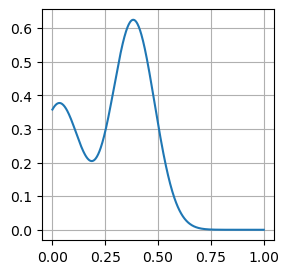

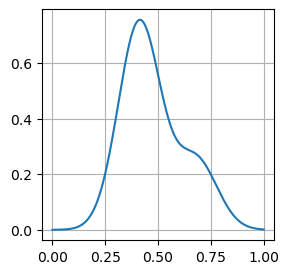

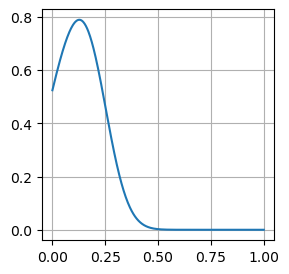

Lengthscale: 0.05
Kappa: 0.1
Kappa: 0.2
Kappa: 0.3
Kappa: 0.4
Max iterations reached
Kappa: 0.5
Max iterations reached
Kappa: 0.6
Kappa: 0.7
Kappa: 0.8
Kappa: 0.9
Kappa: 1.0
Max iterations reached
Kappa: 1.1
Kappa: 1.2
Max iterations reached
Kappa: 1.3
Kappa: 1.4
Kappa: 1.5
Kappa: 1.6
Kappa: 1.7
Kappa: 1.8
Max iterations reached
Kappa: 1.9
Lengthscale: 0.1
Kappa: 0.1
Kappa: 0.2
Kappa: 0.3
Kappa: 0.4
Kappa: 0.5
Kappa: 0.6
Kappa: 0.7
Kappa: 0.8
Max iterations reached
Kappa: 0.9
Max iterations reached
Kappa: 1.0
Max iterations reached
Kappa: 1.1
Max iterations reached
Kappa: 1.2
Max iterations reached
Kappa: 1.3
Max iterations reached
Kappa: 1.4
Max iterations reached
Kappa: 1.5
Max iterations reached
Kappa: 1.6
Max iterations reached
Kappa: 1.7
Max iterations reached
Kappa: 1.8
Max iterations reached
Kappa: 1.9
Max iterations reached
Lengthscale: 0.15000000000000002
Kappa: 0.1
Kappa: 0.2
Kappa: 0.3
Kappa: 0.4
Kappa: 0.5
Max iterations reached
Kappa: 0.6
Max iterations reached
Kappa: 0.7


In [36]:
#ucb_kappa = 3
#rbf_lengthscale = 0.2 # lengthscale parameter
test_functions = []
for i in range(3):
    testmu1 = random.random()
    testmu2 = random.random()
    testalpha2 = random.uniform(0.3, 0.9)
    oned = one_d_test(mu1=testmu1, mu2=testmu2, alpha2=testalpha2)
    test_functions.append(oned)
    plot_oned_objective(oned) # to see what we're dealing with

results = []
for rbf_lengthscale in np.arange(0.05, 0.25, 0.05):
    print("Lengthscale:", rbf_lengthscale)
    for kappa in np.arange(0.1, 2.00, 0.1):
        ucb_kappa = round(kappa, 2)
        print("Kappa:", ucb_kappa)
        fn = 0
        fn_result = []
        fn_result.append(rbf_lengthscale)
        fn_result.append(ucb_kappa)
        for oned in test_functions:
            iterations_required = test_on_oned(rbf_lengthscale, ucb_kappa, oned, 20)
            fn_result.append(iterations_required)
            #print("Lengthscale:", rbf_lengthscale, "Kappa:", ucb_kappa, "Function:", fn, "Needed:", iterations_required)
            fn+=1
        results.append(fn_result)

#print(results)
headers = ["Lengthscale", "Acq kappa"]
for i in range(len(test_functions)):
    headers.append("Function " + str(i))
with open('out.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    writer.writerows(results)

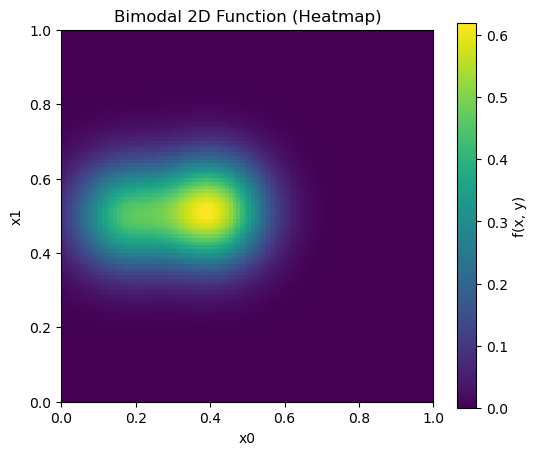

Max from grid search: 0.6183281566510634


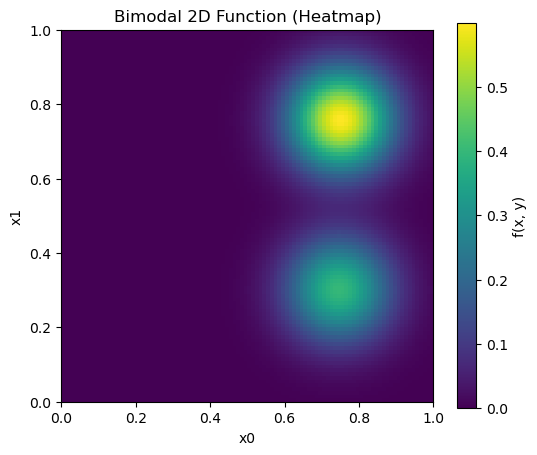

Max from grid search: 0.5989531174355879


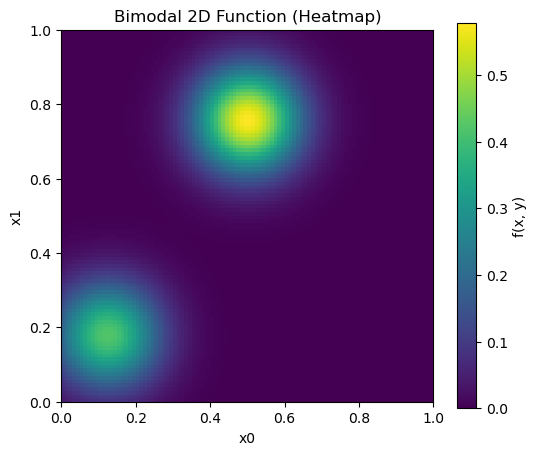

Max from grid search: 0.5774847799113044
Lengthscale: 0.05
Kappa: 0.1
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Lengthscale: 0.05 Kappa: 0.1 Function: 0 Needed: 4
Max y: [0.41224848]
Max y: [0.41224848]
Max y: [0.56250832]
Max y: [0.56250832]
Max y: [0.56250832]
Max y: [0.56250832]
Max y: [0.56250832]
Max y: [0.56250832]
Max y: [0.56250832]
Max y: [0.56250832]
Max y: [0.56250832]
Max y: [0.56250832]
Max y: [0.56250832]
Max y: [0.56250832]
Max y: [0.56250832]
Max y: [0.56250832]
Max y: [0.56250832]
Max y: [0.56250832]
Max y: [0.56250832]
Max y: [0.56250832]
Max y: [0.56250832]
Max iterations reached
Lengthscale: 0.05 Kappa: 0.1 Function: 1 Needed: 0
Max y: [0.25500289]
Max y: [0.25500289]
Max y: [0.56283838]
Max y: [0.56283838]
Max y: [0.56283838]
Max y: [0.56283838]
Lengthscale: 0.05 Kappa: 0.1 Function: 2 Needed: 6
Kappa: 0.2
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.40495413]
Max y: [0.40495413]
Max y: [0.40495413]
Lengthscale: 0.05 Kappa

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.52704637]
Max y: [0.52704637]
Max y: [0.56403014]
Max y: [0.56403014]
Max y: [0.56403014]
Max y: [0.56403014]
Max y: [0.56403014]
Lengthscale: 0.05 Kappa: 0.2 Function: 2 Needed: 18
Kappa: 0.3
Max y: [0.36435343]
Max y: [0.58256782]
Max y: [0.58256782]
Max y: [0.58256782]
Max y: [0.58256782]
Max y: [0.59659465]
Lengthscale: 0.05 Kappa: 0.3 Function: 0 Needed: 6
Max y: [0.08068323]
Max y: [0.08068323]
Max y: [0.08068323]
Max y: [0.08068323]
Max y: [0.44129286]
Max y: [0.44129286]
Max y: [0.44129286]
Max y: [0.44129286]
Max y: [0.44129286]
Max y: [0.44129286]
Max y: [0.44129286]
Max y: [0.44129286]
Max y: [0.44129286]
Max y: [0.44129286]
Max y: [0.44129286]
Max y: [0.44129286]
Max y: [0.44129286]
Max y: [0.44129286]
Max y: [0.44129286]
Max y: [0.44129286]
Max y: [0.44129286]
Max iterations reached
Lengthscale: 0.05 Kappa: 0.3 Function: 1 Needed: 0
Max y: [0.02050658]
Max y: [0.02050658]
Max y: [0.29705101]
Max y: [0.4386825]
Max y: [0.4386825]
Max y: [0.4386825]
Max y: [0.43868

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.56127318]
Max y: [0.56127318]
Max y: [0.56127318]
Max y: [0.56127318]
Max y: [0.56127318]
Max y: [0.56127318]
Max iterations reached
Lengthscale: 0.05 Kappa: 1.0 Function: 2 Needed: 0
Kappa: 1.1
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.37249248]
Max y: [0.57842704]
Max y: [0.57842704]
Max y: [0.57842704]
Max y: [0.57842704]
Max y: [0.57842704]
Max y: [0.57842704]
Max y: [0.57842704]
Max y: [0.57842704]
Lengthscale: 0.05 Kappa: 1.1 Function: 0 Needed: 14
Max y: [0.09300551]
Max y: [0.09300551]
Max y: [0.09300551]
Max y: [0.29100763]
Max y: [0.29100763]
Max y: [0.29100763]
Max y: [0.29100763]
Max y: [0.29100763]
Max y: [0.29100763]
Max y: [0.29100763]
Max y: [0.29100763]
Max y: [0.29100763]
Max y: [0.29100763]
Max y: [0.29100763]
Max y: [0.29100763]
Max y: [0.38066003]
Max y: [0.38066003]
Max y: [0.38066003]
Max y: [0.38066003]
Max y: [0.38066003]
Max y: [0.38066003]
Max iterations reached
Lengthscale: 0.05 Ka

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.33981528]
Max iterations reached
Lengthscale: 0.1 Kappa: 1.3 Function: 1 Needed: 0
Max y: [0.0888525]
Max y: [0.0888525]
Max y: [0.0888525]
Max y: [0.0888525]
Max y: [0.10636359]
Max y: [0.41934116]
Max y: [0.41934116]
Max y: [0.41934116]
Max y: [0.41934116]
Max y: [0.55713158]
Max y: [0.55713158]
Max y: [0.55713158]
Max y: [0.55713158]
Max y: [0.55713158]
Max y: [0.55713158]
Max y: [0.55713158]
Max y: [0.55713158]
Max y: [0.55713158]
Lengthscale: 0.1 Kappa: 1.3 Function: 2 Needed: 18
Kappa: 1.4
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.49837346]
Max y: [0.56692684]
Max y: [0.60554979]
Max y: [0.60554979]
Max y: [0.60554979]
Max y: [0.60554979]
Lengthscale: 0.1 Kappa: 1.4 Function: 0 Needed: 14
Max y: [0.07335027]
Max y: [0.07335027]
Max y: [0.07335027]
Max y: [0.07335027]
Max y: [0.5766257]
Max y: [0.5766257]
Max y: [0.5766257]
Max y: [0.5766257]
Ma

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.54275902]
Max y: [0.54275902]
Max y: [0.54275902]
Max y: [0.54275902]
Max y: [0.54275902]
Max y: [0.54275902]
Max y: [0.54275902]
Max y: [0.54275902]
Max y: [0.54275902]
Max y: [0.54275902]
Max y: [0.54275902]
Max y: [0.54275902]
Max iterations reached
Lengthscale: 0.1 Kappa: 1.4 Function: 2 Needed: 0
Kappa: 1.5
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.60336112]
Max y: [0.60336112]
Max y: [0.60336112]
Lengthscale: 0.1 Kappa: 1.5 Function: 0 Needed: 10
Max y: [0.2284711]
Max y: [0.2284711]
Max y: [0.2284711]
Max y: [0.36939597]
Max y: [0.36939597]
Max y: [0.36939597]
Max y: [0.36939597]
Max y: [0.36939597]
Max y: [0.36939597]
Max y: [0.36939597]
Max y: [0.36939597]
Max y: [0.36939597]
Max y: [0.36939597]
Max y: [0.36939597]
Max y: [0.36939597]
Max y: [0.36939597]
Max y: [0.36939597]
Max y: [0.36939597]
Max y: [0.36939597]
Max y: [0.36939597]
Max y: [0.40955611]
Max iter

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.4001832]
Max iterations reached
Lengthscale: 0.15000000000000002 Kappa: 0.2 Function: 1 Needed: 0
Max y: [0.37731912]
Max y: [0.37731912]
Max y: [0.37731912]
Max y: [0.37731912]
Max y: [0.37731912]
Max y: [0.37731912]
Lengthscale: 0.15000000000000002 Kappa: 0.2 Function: 2 Needed: 6
Kappa: 0.3
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.58322054]
Max y: [0.58322054]
Max y: [0.58322054]
Max y: [0.60782413]
Lengthscale: 0.15000000000000002 Kappa: 0.3 Function: 0 Needed: 9
Max y: [0.16697193]
Max y: [0.16697193]
Max y: [0.16697193]
Max y: [0.16697193]
Max y: [0.16697193]
Max y: [0.2853093]
Max y: [0.2853093]
Max y: [0.2853093]
Max y: [0.2853093]
Max y: [0.2853093]
Max y: [0.2853093]
Max y: [0.2853093]
Max y: [0.2853093]
Max y: [0.2853093]
Max y: [0.39693494]
Max y: [0.39693494]
Max y: [0.39693494]
Max y: [0.39693494]
Max y: [0.39693494]
Max y: [0.39693494]
Max y: [0.39693494]
Max iterations reached
Lengthscale: 0.

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.48446608]
Max y: [0.48446608]
Max iterations reached
Lengthscale: 0.15000000000000002 Kappa: 0.6 Function: 1 Needed: 0
Max y: [0.40168668]
Max y: [0.40168668]
Max y: [0.40168668]
Max y: [0.40168668]
Max y: [0.40168668]
Max y: [0.40168668]
Max y: [0.45604184]
Max y: [0.55538879]
Max y: [0.55538879]
Max y: [0.55538879]
Max y: [0.55538879]
Max y: [0.55538879]
Max y: [0.55538879]
Max y: [0.55538879]
Max y: [0.55538879]
Max y: [0.55538879]
Max y: [0.55538879]
Max y: [0.55538879]
Max y: [0.55538879]
Max y: [0.55538879]
Max y: [0.55538879]
Max iterations reached
Lengthscale: 0.15000000000000002 Kappa: 0.6 Function: 2 Needed: 0
Kappa: 0.7
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.55322199]
Max y: [0.55322199]
Max y: [0.55322199]
Max y: [0.55322199]
Max y: [0.55322199]
Max y: [0.55322199]
Max y: [0.55322199]
Max y: [0.60646486]
Max y: [0.60646486]
Lengthscale: 0.15000000000000002 Kappa: 0.7 Function: 0 Needed: 11
Max y: [0.1674562]
Max y: [0.1674562]
Max y: [0.43758742]
Max y:

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Lengthscale: 0.15000000000000002 Kappa: 1.0 Function: 2 Needed: 19
Kappa: 1.1
Max y: [0.370663]
Max y: [0.370663]
Max y: [0.58292885]
Max y: [0.58292885]
Max y: [0.58292885]
Max y: [0.58292885]
Max y: [0.58292885]
Max y: [0.58292885]
Lengthscale: 0.15000000000000002 Kappa: 1.1 Function: 0 Needed: 8
Max y: [0.00420229]
Max y: [0.00420229]
Max y: [0.06577207]
Max y: [0.06577207]
Max y: [0.37108831]
Max y: [0.37108831]
Max y: [0.37108831]
Max y: [0.37108831]
Max y: [0.37108831]
Max y: [0.37108831]
Max y: [0.3975134]
Max y: [0.3975134]
Max y: [0.3975134]
Max y: [0.3975134]
Max y: [0.3975134]
Max y: [0.3975134]
Max y: [0.3975134]
Max y: [0.3975134]
Max y: [0.3975134]
Max y: [0.3975134]
Max y: [0.3975134]
Max iterations reached
Lengthscale: 0.15000000000000002 Kappa: 1.1 Function: 1 Needed: 0
Max y: [0.20279335]
Max y: [0.20279335]
Max y: [0.20279335]
Max y: [0.20279335]
Max y: [0.419339]
Max y: [0.419339]
Max y: [0.419339]
Max y: [0.56047343]
Max y: [0.56047343]
Max y: [0.56047343]
Max y: [

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.28129269]
Max y: [0.28129269]
Max iterations reached
Lengthscale: 0.15000000000000002 Kappa: 1.2 Function: 1 Needed: 0
Max y: [0.34524669]
Max y: [0.34524669]
Max y: [0.34524669]
Max y: [0.34524669]
Max y: [0.34524669]
Max y: [0.34524669]
Max y: [0.34524669]
Max y: [0.34524669]
Max y: [0.34524669]
Max y: [0.34524669]
Max y: [0.34524669]
Max y: [0.34524669]
Max y: [0.34524669]
Max y: [0.34524669]
Lengthscale: 0.15000000000000002 Kappa: 1.2 Function: 2 Needed: 14
Kappa: 1.3
Max y: [0.44341441]
Max y: [0.44341441]
Max y: [0.44341441]
Max y: [0.44341441]
Max y: [0.44341441]
Max y: [0.44341441]
Max y: [0.44341441]
Max y: [0.44341441]
Max y: [0.60554884]
Max y: [0.60554884]
Lengthscale: 0.15000000000000002 Kappa: 1.3 Function: 0 Needed: 10
Max y: [0.41489307]
Max y: [0.41489307]
Max y: [0.4449303]
Max y: [0.57776244]
Max y: [0.57776244]
Max y: [0.57776244]
Max y: [0.57776244]
Max y: [0.57776244]
Max y: [0.57776244]
Max y: [0.57776244]
Max y: [0.57776244]
Max y: [0.57776244]
Max y: 

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.05479003]
Max y: [0.05479003]
Max y: [0.05479003]
Max y: [0.45606038]
Max y: [0.45606038]
Max y: [0.51738069]
Max y: [0.51738069]
Max y: [0.5538251]
Max y: [0.5538251]
Max y: [0.5538251]
Max y: [0.5538251]
Lengthscale: 0.2 Kappa: 0.1 Function: 2 Needed: 15
Kappa: 0.2
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.4745952]
Max y: [0.4745952]
Max y: [0.60603572]
Lengthscale: 0.2 Kappa: 0.2 Function: 0 Needed: 8
Max y: [0.33600213]
Max y: [0.33600213]
Max y: [0.39858861]
Max y: [0.39858861]
Max y: [0.39858861]
Max y: [0.39858861]
Max y: [0.39858861]
Max y: [0.39858861]
Max y: [0.39858861]
Max y: [0.39858861]
Max y: [0.39858861]
Max y: [0.39858861]
Max y: [0.51203046]
Max y: [0.51203046]
Max y: [0.51203046]
Max y: [0.51203046]
Max y: [0.51203046]
Max y: [0.51203046]
Max y: [0.51203046]
Max y: [0.51203046]
Max y: [0.51203046]
Max iterations reached
Lengthscale: 0.2 Kappa: 0.2 Function: 1 Needed: 0
Max y: [0.09504674]
M

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.38207272]
Max y: [0.4833288]
Max y: [0.55422843]
Max y: [0.57128099]
Max iterations reached
Lengthscale: 0.2 Kappa: 1.3 Function: 1 Needed: 0
Max y: [0.14653481]
Max y: [0.14653481]
Max y: [0.14653481]
Max y: [0.14653481]
Max y: [0.14653481]
Max y: [0.14653481]
Max y: [0.14653481]
Max y: [0.14653481]
Max y: [0.14653481]
Max y: [0.14653481]
Max y: [0.14653481]
Max y: [0.27057949]
Max y: [0.40871059]
Lengthscale: 0.2 Kappa: 1.3 Function: 2 Needed: 13
Kappa: 1.4
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.47488378]
Max y: [0.47488378]
Max y: [0.47488378]
Max y: [0.47488378]
Max y: [0.47488378]
Max y: [0.51854589]
Max y: [0.60113639]
Max y: [0.60113639]
Lengthscale: 0.2 Kappa: 1.4 Function: 0 Needed: 11
Max y: [0.22677188]
Max y: [0.22677188]
Max y: [0.22677188]
Max y: [0.22677188]
Max y: [0.22677188]
Max y: [0.22677188]
Max y: [0.22677188]
Max y: [0.56976765]
Max y: [0.56976765]
Max y: [0.56976765]
Max y: [0.56976765]
Max y: [0.56976765]
Max y: [0.56976

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.53896308]
Max y: [0.53896308]
Max y: [0.53896308]
Max y: [0.53896308]
Max y: [0.53896308]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.53896308]
Max y: [0.53896308]
Max y: [0.53896308]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/prepro

Max y: [0.53896308]
Max y: [0.53896308]
Max y: [0.53896308]
Max y: [0.53896308]
Max y: [0.53896308]
Max iterations reached
Lengthscale: 0.2 Kappa: 1.9 Function: 1 Needed: 0
Max y: [0.12548451]
Max y: [0.12548451]
Max y: [0.12548451]
Max y: [0.12548451]
Max y: [0.12548451]
Max y: [0.50477195]
Max y: [0.50477195]
Max y: [0.50477195]
Max y: [0.50477195]
Max y: [0.50477195]
Max y: [0.50477195]
Max y: [0.50828157]
Max y: [0.56075775]
Max y: [0.56075775]
Max y: [0.56075775]
Max y: [0.56075775]
Max y: [0.56075775]
Max y: [0.56075775]
Max y: [0.56075775]
Max y: [0.56075775]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.56075775]
Max iterations reached
Lengthscale: 0.2 Kappa: 1.9 Function: 2 Needed: 0
Lengthscale: 0.25
Kappa: 0.1
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.53402652]
Max y: [0.53402652]
Max y: [0.53402652]
Max y: [0.60549306]
Max y: [0.60549306]
Max y: [0.6069709]
Max y: [0.6069709]
Max y: [0.6069709]
Max y: [0.6069709]
Lengthscale: 0.25 Kappa: 0.1 Function: 0 Needed: 11
Max y: [0.22343483]
Max y: [0.22343483]
Max y: [0.2520678]
Max y: [0.2520678]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.2520678]
Max y: [0.37555176]
Max y: [0.38173347]
Max y: [0.38173347]
Max y: [0.38173347]
Max y: [0.38173347]
Max y: [0.38173347]
Max y: [0.39512397]
Max y: [0.39512397]
Max y: [0.39512397]
Max y: [0.39512397]
Max y: [0.39512397]
Max y: [0.39512397]
Max y: [0.39512397]
Max y: [0.39512397]
Max y: [0.39512397]
Max y: [0.39512397]
Max iterations reached
Lengthscale: 0.25 Kappa: 0.1 Function: 1 Needed: 0
Max y: [0.37564154]
Max y: [0.37564154]
Max y: [0.37564154]
Max y: [0.37564154]
Max y: [0.37564154]
Max y: [0.37564154]
Max y: [0.40426332]
Max y: [0.49249743]
Max y: [0.49863915]
Max y: [0.56060449]
Max y: [0.56192502]
Max y: [0.56192502]
Max y: [0.56192502]
Max y: [0.56192502]
Max y: [0.56192502]
Max y: [0.56192502]
Max y: [0.56192502]
Max y: [0.56192502]
Lengthscale: 0.25 Kappa: 0.1 Function: 2 Needed: 18
Kappa: 0.2
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.49050394]
Max y: [0.54876123]
Max y: [0.54876123]
Max y: [0.54876123]
Lengthscale: 0.25 Kappa: 0.2 Function: 0 Nee

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.3254145]
Max y: [0.3254145]
Max y: [0.3254145]
Max y: [0.3254145]
Max y: [0.3254145]
Max y: [0.3254145]
Max y: [0.3254145]
Max y: [0.3254145]
Max y: [0.3254145]
Max y: [0.3254145]
Max y: [0.3254145]
Max y: [0.3254145]
Max y: [0.3254145]
Max y: [0.40009031]
Max y: [0.40009031]
Max y: [0.40009031]
Max y: [0.40009031]
Max y: [0.40009031]
Max iterations reached
Lengthscale: 0.25 Kappa: 0.5 Function: 1 Needed: 0
Max y: [0.26888107]
Max y: [0.26888107]
Max y: [0.28260393]
Max y: [0.28260393]
Max y: [0.28260393]
Max y: [0.28260393]
Max y: [0.28260393]
Max y: [0.28260393]
Max y: [0.36268686]
Max y: [0.50541811]
Max y: [0.50541811]
Max y: [0.50541811]
Max y: [0.53451228]
Lengthscale: 0.25 Kappa: 0.5 Function: 2 Needed: 13
Kappa: 0.6
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.49296239]
Max y: [0.49296239]
Max y: [0.5563522]
Lengthscale: 0.25 Kappa: 0.6 Function: 0 Needed: 9
Max y: [0.44827212]
Max y:

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.31363059]
Max y: [0.31363059]
Max y: [0.31363059]
Max y: [0.31363059]
Max y: [0.31363059]
Max y: [0.31363059]
Max y: [0.31363059]
Max y: [0.31363059]
Max y: [0.31363059]
Max y: [0.31363059]
Max y: [0.31363059]
Max y: [0.31363059]
Max y: [0.31363059]
Max y: [0.31363059]
Max y: [0.31363059]
Max y: [0.31363059]
Max y: [0.31363059]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.31363059]
Max y: [0.31363059]
Max iterations reached
Lengthscale: 0.25 Kappa: 0.8 Function: 1 Needed: 0
Max y: [0.41837019]
Max y: [0.41837019]
Max y: [0.41837019]
Max y: [0.41837019]
Max y: [0.41837019]
Max y: [0.41837019]
Max y: [0.55165456]
Max y: [0.55165456]
Max y: [0.55165456]
Max y: [0.55165456]
Max y: [0.55776297]
Max y: [0.55776297]
Max y: [0.55776297]
Max y: [0.55776297]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.55776297]
Max y: [0.55776297]
Max y: [0.55776297]
Max y: [0.55776297]
Max y: [0.55776297]
Max y: [0.55776297]
Max y: [0.55776297]
Max iterations reached
Lengthscale: 0.25 Kappa: 0.8 Function: 2 Needed: 0
Kappa: 0.9
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.48227117]
Max y: [0.5149793]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.5149793]
Max y: [0.5149793]
Max y: [0.5149793]
Max y: [0.57967879]
Lengthscale: 0.25 Kappa: 0.9 Function: 0 Needed: 8
Max y: [0.03201772]
Max y: [0.03201772]
Max y: [0.03201772]
Max y: [0.58188221]
Max y: [0.58188221]
Max y: [0.58188221]
Max y: [0.58188221]
Max y: [0.58188221]
Max y: [0.58188221]
Max y: [0.58188221]
Max y: [0.58188221]
Max y: [0.58188221]
Max y: [0.58188221]
Max y: [0.58188221]
Max y: [0.58188221]
Max y: [0.58188221]
Max y: [0.58188221]
Max y: [0.58188221]
Max y: [0.58188221]
Max y: [0.58188221]
Max y: [0.58188221]
Max iterations reached
Lengthscale: 0.25 Kappa: 0.9 Function: 1 Needed: 0
Max y: [0.1428113]
Max y: [0.1428113]
Max y: [0.1428113]
Max y: [0.1428113]
Max y: [0.42718668]
Max y: [0.42718668]
Max y: [0.42718668]
Max y: [0.42718668]
Max y: [0.46840507]
Max y: [0.46840507]
Max y: [0.46840507]
Max y: [0.46840507]
Max y: [0.46840507]
Max y: [0.46840507]
Max y: [0.46840507]
Lengthscale: 0.25 Kappa: 0.9 Function: 2 Needed: 15
Kappa: 1.0
Max y: [0.36435343]

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.55952961]
Max y: [0.55952961]
Max y: [0.55952961]
Max y: [0.55952961]
Max y: [0.55952961]
Max y: [0.55952961]
Max iterations reached
Lengthscale: 0.25 Kappa: 1.0 Function: 2 Needed: 0
Kappa: 1.1
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.47149906]
Max y: [0.47149906]
Max y: [0.47149906]
Max y: [0.47149906]
Max y: [0.57728583]
Max y: [0.57728583]
Max y: [0.58610576]
Max y: [0.58721995]
Max y: [0.58721995]
Max y: [0.58721995]
Max y: [0.58721995]
Lengthscale: 0.25 Kappa: 1.1 Function: 0 Needed: 15
Max y: [0.01589828]
Max y: [0.01589828]
Max y: [0.01589828]
Max y: [0.01589828]
Max y: [0.01589828]
Max y: [0.01589828]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.01589828]
Max y: [0.1717526]
Max y: [0.1717526]
Max y: [0.1717526]
Max y: [0.20532735]
Max y: [0.20532735]
Max y: [0.5412537]
Max y: [0.5412537]
Max y: [0.5412537]
Max y: [0.5412537]
Max y: [0.5412537]
Max y: [0.5412537]
Max y: [0.5412537]
Max y: [0.5412537]
Max y: [0.5412537]
Max iterations reached
Lengthscale: 0.25 Kappa: 1.1 Function: 1 Needed: 0
Max y: [0.13636708]
Max y: [0.13636708]
Max y: [0.13636708]
Max y: [0.13636708]
Max y: [0.13636708]
Max y: [0.13636708]
Max y: [0.13636708]
Max y: [0.36298797]
Max y: [0.52764653]
Max y: [0.52764653]
Max y: [0.52764653]
Max y: [0.52764653]
Max y: [0.52764653]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.52764653]
Max y: [0.52764653]
Max y: [0.52764653]
Max y: [0.52764653]
Max y: [0.52764653]
Max y: [0.52764653]
Max y: [0.52764653]
Max y: [0.52764653]
Max iterations reached
Lengthscale: 0.25 Kappa: 1.1 Function: 2 Needed: 0
Kappa: 1.2
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.56621866]
Max y: [0.56621866]
Max y: [0.56621866]
Max y: [0.56621866]
Max y: [0.56621866]
Max y: [0.56621866]
Max y: [0.56621866]
Max y: [0.5962982]
Max y: [0.5962982]
Lengthscale: 0.25 Kappa: 1.2 Function: 0 Needed: 12
Max y: [0.19461693]
Max y: [0.19461693]
Max y: [0.19461693]
Max y: [0.47890889]
Max y: [0.47890889]
Max y: [0.47890889]
Max y: [0.47890889]
Max y: [0.47890889]
Max y: [0.47890889]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.47890889]
Max y: [0.47890889]
Max y: [0.47890889]
Max y: [0.47890889]
Max y: [0.47890889]
Max y: [0.47890889]
Max y: [0.47890889]
Max y: [0.47890889]
Max y: [0.47890889]
Max y: [0.47890889]
Max y: [0.47890889]
Max y: [0.47890889]
Max iterations reached
Lengthscale: 0.25 Kappa: 1.2 Function: 1 Needed: 0
Max y: [0.17782331]
Max y: [0.17782331]
Max y: [0.17782331]
Max y: [0.17782331]
Max y: [0.17782331]
Max y: [0.17782331]
Max y: [0.17782331]
Lengthscale: 0.25 Kappa: 1.2 Function: 2 Needed: 7
Kappa: 1.3
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Lengthscale: 0.25 Kappa: 1.3 Function: 0 Needed: 7
Max y: [0.00614142]
Max y: [0.00614142]
Max y: [0.00614142]
Max y: [0.01670303]
Max y: [0.02724141]
Max y: [0.02724141]
Max y: [0.21058415]
Max y: [0.21058415]
Max y: [0.28754815]
Max y: [0.30697278]
Max y: [0.30697278]
Max y: [0.30697278]
Max y: [0.30697278]
Max y: [0.30697278]
Max y: [0.306

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.49763754]
Max y: [0.49763754]
Max y: [0.49763754]
Max y: [0.49763754]
Max y: [0.49763754]
Max y: [0.49763754]
Max y: [0.49763754]
Max iterations reached
Lengthscale: 0.25 Kappa: 1.6 Function: 2 Needed: 0
Kappa: 1.7
Max y: [0.47153711]
Max y: [0.47153711]
Max y: [0.47153711]
Max y: [0.47153711]
Max y: [0.47153711]
Max y: [0.47153711]
Max y: [0.47153711]
Max y: [0.47153711]
Max y: [0.47153711]
Max y: [0.47153711]
Max y: [0.6002141]
Max y: [0.6002141]
Max y: [0.6002141]
Lengthscale: 0.25 Kappa: 1.7 Function: 0 Needed: 13
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max y: [0.53883698]
Max iterations reached
Lengthscale: 0.25 Kappa

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.39362651]
Max y: [0.39362651]
Max y: [0.39362651]
Max y: [0.39362651]
Max y: [0.39362651]
Max y: [0.42331916]
Max y: [0.42331916]
Max y: [0.42331916]
Max y: [0.42331916]
Max y: [0.42331916]
Max y: [0.42331916]
Max y: [0.42331916]
Max y: [0.42331916]
Max y: [0.42331916]
Max y: [0.42331916]
Max y: [0.42331916]
Max y: [0.42331916]
Max iterations reached
Lengthscale: 0.25 Kappa: 1.9 Function: 1 Needed: 0
Max y: [0.02050658]
Max y: [0.02050658]
Max y: [0.02050658]
Max y: [0.02050658]
Max y: [0.05157632]
Max y: [0.05157632]
Max y: [0.45938468]
Max y: [0.45938468]
Max y: [0.45938468]
Max y: [0.45938468]
Max y: [0.45938468]
Max y: [0.45938468]
Max y: [0.56127321]
Max y: [0.56127321]
Max y: [0.56127321]
Max y: [0.56127321]
Max y: [0.56127321]
Max y: [0.56127321]
Max y: [0.56127321]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\

Max y: [0.56127321]
Max y: [0.56127321]
Max iterations reached
Lengthscale: 0.25 Kappa: 1.9 Function: 2 Needed: 0
Lengthscale: 0.3
Kappa: 0.1
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.46125918]
Max y: [0.46125918]
Max y: [0.46125918]
Max y: [0.46125918]
Max y: [0.6056252]
Max y: [0.6056252]
Lengthscale: 0.3 Kappa: 0.1 Function: 0 Needed: 8
Max y: [0.39048801]
Max y: [0.39048801]
Max y: [0.39048801]
Max y: [0.39048801]
Max y: [0.39674935]
Max y: [0.39674935]
Max y: [0.39674935]
Max y: [0.39674935]
Max y: [0.39674935]
Max y: [0.39674935]
Max y: [0.39674935]
Max y: [0.39674935]
Max y: [0.52964274]
Max y: [0.52964274]
Max y: [0.52964274]
Max y: [0.52964274]
Max y: [0.52964274]
Max y: [0.52964274]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.52964274]
Max y: [0.52964274]
Max y: [0.52964274]
Max iterations reached
Lengthscale: 0.3 Kappa: 0.1 Function: 1 Needed: 0
Max y: [0.21809818]
Max y: [0.21809818]
Max y: [0.21809818]
Max y: [0.54159156]
Max y: [0.54159156]
Max y: [0.54159156]
Max y: [0.54159156]
Max y: [0.54159156]
Max y: [0.54159156]
Max y: [0.54159156]
Max y: [0.54159156]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Lengthscale: 0.3 Kappa: 0.1 Function: 2 Needed: 11
Kappa: 0.2
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.52640152]
Max y: [0.52640152]
Max y: [0.52640152]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.52640152]
Lengthscale: 0.3 Kappa: 0.2 Function: 0 Needed: 8
Max y: [0.14753857]
Max y: [0.14753857]
Max y: [0.14753857]
Max y: [0.58138134]
Max y: [0.58138134]
Max y: [0.58138134]
Max y: [0.58138134]
Max y: [0.58138134]
Max y: [0.58138134]
Max y: [0.58138134]
Max y: [0.58138134]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.58138134]
Max y: [0.58138134]
Max y: [0.58138134]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.58138134]
Max y: [0.58138134]
Max y: [0.58138134]
Max y: [0.58138134]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.58138134]
Max y: [0.58138134]
Max y: [0.58138134]
Max iterations reached
Lengthscale: 0.3 Kappa: 0.2 Function: 1 Needed: 0
Max y: [0.35755401]
Max y: [0.35755401]
Max y: [0.35755401]
Max y: [0.35755401]
Max y: [0.35755401]
Max y: [0.4929954]
Max y: [0.4929954]
Max y: [0.4929954]
Max y: [0.4929954]
Lengthscale: 0.3 Kappa: 0.2 Function: 2 Needed: 9
Kappa: 0.3
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Lengthscale: 0.3 Kappa: 0.3 Function: 0 Needed: 3
Max y: [0.31997215]
Max y: [0.31997215]
Max y: [0.31997215]
Max y: [0.31997215]
Max y: [0.45884585]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.45884585]
Max y: [0.45884585]
Max y: [0.45884585]
Max y: [0.45884585]
Max y: [0.45884585]
Max y: [0.45884585]
Max y: [0.45884585]
Max y: [0.45884585]
Max y: [0.45884585]
Max y: [0.45884585]
Max y: [0.45884585]
Max y: [0.45884585]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.45884585]
Max y: [0.45884585]
Max y: [0.45884585]
Max y: [0.45884585]
Max iterations reached
Lengthscale: 0.3 Kappa: 0.3 Function: 1 Needed: 0
Max y: [0.23236498]
Max y: [0.23236498]
Max y: [0.23236498]
Lengthscale: 0.3 Kappa: 0.3 Function: 2 Needed: 3
Kappa: 0.4
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.50609508]
Max y: [0.52562829]
Max y: [0.52562829]
Max y: [0.52562829]
Lengthscale: 0.3 Kappa: 0.4 Function: 0 Needed: 8
Max y: [0.0256023]
Max y: [0.0256023]
Max y: [0.0256023]
Max y: [0.25376688]
Max y: [0.25376688]
Max y: [0.25376688]
Max y: [0.43199946]
Max y: [0.43199946]
Max y: [0.43199946]
Max y: [0.43199946]
Max y: [0.43199946]
Max y: [0.43199946]
Max y: [0.43199946]
Max y: [0.43199946]
Max y: [0.43199946]
Max y: [0.43199946]
Max y: [0.43199946]
Max y: [0.43199946]
Max y: [0.43199946]
Max y: [0.43199946]
Max y: [0.54383464]
Max iterations reached
Lengthscale: 0.3 Kappa: 0.4 Function: 1 Needed: 0
Max y: [0.07008063]
Max y:

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.46160114]
Max y: [0.46160114]
Max y: [0.46160114]
Max y: [0.46160114]
Max y: [0.5834292]
Max y: [0.5834292]
Max y: [0.59355402]
Lengthscale: 0.3 Kappa: 0.5 Function: 0 Needed: 8
Max y: [0.12160737]
Max y: [0.12160737]
Max y: [0.12160737]
Max y: [0.18185561]
Max y: [0.18185561]
Max y: [0.18185561]
Max y: [0.18185561]
Max y: [0.18185561]
Max y: [0.32874909]
Max y: [0.35279258]
Max y: [0.49530433]
Max y: [0.49530433]
Max y: [0.49530433]
Max y: [0.49530433]
Max y: [0.49530433]
Max y: [0.49530433]
Max y: [0.49530433]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.49530433]
Max y: [0.49530433]
Max y: [0.49530433]
Max y: [0.49530433]
Max iterations reached
Lengthscale: 0.3 Kappa: 0.5 Function: 1 Needed: 0
Max y: [0.07542696]
Max y: [0.07542696]
Max y: [0.07542696]
Max y: [0.07542696]
Max y: [0.07542696]
Max y: [0.07542696]
Max y: [0.07542696]
Max y: [0.48553636]
Max y: [0.50425104]
Max y: [0.50425104]
Max y: [0.50425104]
Max y: [0.56309071]
Max y: [0.56309071]
Max y: [0.56309071]
Max y: [0.56309071]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.56309071]
Max y: [0.56309071]
Max y: [0.56309071]
Max y: [0.56309071]
Max y: [0.56309071]
Max y: [0.56309071]
Max iterations reached
Lengthscale: 0.3 Kappa: 0.5 Function: 2 Needed: 0
Kappa: 0.6
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.42433147]
Lengthscale: 0.3 Kappa: 0.6 Function: 0 Needed: 4
Max y: [0.40182075]
Max y: [0.40182075]
Max y: [0.40182075]
Max y: [0.40182075]
Max y: [0.40182075]
Max y: [0.40182075]
Max y: [0.40182075]
Max y: [0.55641992]
Lengthscale: 0.3 Kappa: 0.6 Function: 1 Needed: 8
Max y: [0.09942703]
Max y: [0.09942703]
Max y: [0.09942703]
Max y: [0.09942703]
Max y: [0.09942703]
Max y: [0.55121733]
Max y: [0.55121733]
Max y: [0.55121733]
Max y: [0.55121733]
Max y: [0.55121733]
Max y: [0.55121733]
Max y: [0.55121733]
Max y: [0.55121733]
Max y: [0.55121733]
Max y: [0.55121733]
Lengthscale: 0.3 Kappa: 0.6 Function: 2 Needed: 15
Kappa: 0.7
Max y: [0.37332829]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.37332829]
Max y: [0.37332829]
Max y: [0.43683366]
Max y: [0.43683366]
Max y: [0.53262338]
Max y: [0.53262338]
Max y: [0.53262338]
Max y: [0.53262338]
Max y: [0.60176663]
Max y: [0.60176663]
Max y: [0.60176663]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.60176663]
Max y: [0.60176663]
Max y: [0.60176663]
Lengthscale: 0.3 Kappa: 0.7 Function: 0 Needed: 15
Max y: [0.11113817]
Max y: [0.11113817]
Max y: [0.11113817]
Max y: [0.38841591]
Max y: [0.38841591]
Max y: [0.38841591]
Max y: [0.38841591]
Max y: [0.38841591]
Max y: [0.38841591]
Max y: [0.38841591]
Max y: [0.38841591]
Max y: [0.38841591]
Max y: [0.38841591]
Max y: [0.38841591]
Max y: [0.38841591]
Max y: [0.38841591]
Max y: [0.38841591]
Max y: [0.38841591]
Max y: [0.38841591]
Max y: [0.38841591]
Max y: [0.38841591]
Max iterations reached
Lengthscale: 0.3 Kappa: 0.7 Function: 1 Needed: 0
Max y: [0.28779386]
Max y: [0.28779386]
Max y: [0.28779386]
Max y: [0.28779386]
Max y: [0.28779386]
Max y: [0.28779386]
Max y: [0.36606437]
Max y: [0.36606437]
Max y: [0.36606437]
Max y: [0.36606437]
Max y: [0.49333592]
Max y: [0.49333592]
Max y: [0.49333592]
Max y: [0.49333592]
Max y: [0.49333592]
Lengthscale: 0.3 Kappa: 0.7 Function: 2 Needed: 15
Kappa: 0.8
Max y: [0.36435343]
Max y: [0.3643

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.47724666]
Max y: [0.51123186]
Max y: [0.51123186]
Max y: [0.5223733]
Max y: [0.5223733]
Lengthscale: 0.3 Kappa: 0.8 Function: 0 Needed: 10
Max y: [0.09930546]
Max y: [0.09930546]
Max y: [0.09930546]
Max y: [0.09930546]
Max y: [0.58366426]
Max y: [0.58366426]
Max y: [0.58366426]
Max y: [0.58366426]
Max y: [0.58366426]
Max y: [0.58366426]
Max y: [0.58366426]
Max y: [0.58366426]
Max y: [0.58366426]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.58366426]
Max y: [0.58366426]
Max y: [0.58366426]
Max y: [0.58366426]
Max y: [0.58407181]
Max y: [0.58407181]
Max y: [0.58407181]
Lengthscale: 0.3 Kappa: 0.8 Function: 1 Needed: 20
Max y: [0.09804144]
Max y: [0.09804144]
Max y: [0.50485659]
Max y: [0.50485659]
Max y: [0.50485659]
Max y: [0.50485659]
Max y: [0.50485659]
Max y: [0.50485659]
Max y: [0.50485659]
Max y: [0.50485659]
Max y: [0.50485659]
Max y: [0.50485659]
Max y: [0.50485659]
Max y: [0.50485659]
Max y: [0.56108692]
Max y: [0.56108692]
Max y: [0.56108692]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.56108692]
Max y: [0.56108692]
Max y: [0.56108692]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.56108692]
Max iterations reached
Lengthscale: 0.3 Kappa: 0.8 Function: 2 Needed: 0
Kappa: 0.9
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.39278371]
Max y: [0.59175544]
Max y: [0.59175544]
Max y: [0.59175544]
Max y: [0.59175544]
Max y: [0.59175544]
Max y: [0.59175544]
Lengthscale: 0.3 Kappa: 0.9 Function: 0 Needed: 11
Max y: [0.04194267]
Max y: [0.04194267]
Max y: [0.04194267]
Max y: [0.04194267]
Max y: [0.04194267]
Max y: [0.37004089]
Max y: [0.37004089]
Max y: [0.37004089]
Max y: [0.37004089]
Max y: [0.37004089]
Max y: [0.37004089]
Max y: [0.37004089]
Max y: [0.37004089]
Max y: [0.37004089]
Max y: [0.37004089]
Max y: [0.37004089]
Max y: [0.38415059]
Max y: [0.38415059]
Max y: [0.38415059]
Max y: [0.38415059]
Max y: [0.38415059]
Max iterations reached
Lengthscale: 0.3 Kappa: 0.9 Function: 1 Needed: 0
Max y: [0.02050658]
Max y: [0.02050658]
Max y: [0.02050658]
Max y: [0.16771294]
Max y: [0.16771294]
Max y: [0.16771294]
Max y: [0.37

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\

Max y: [0.5265498]
Max y: [0.5265498]
Max y: [0.5265498]
Max y: [0.5265498]
Max y: [0.5265498]
Max y: [0.5265498]
Lengthscale: 0.3 Kappa: 0.9 Function: 2 Needed: 17
Kappa: 1.0
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.49454619]
Max y: [0.49454619]
Max y: [0.49454619]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.49454619]
Max y: [0.49454619]
Max y: [0.49454619]
Max y: [0.58424359]
Max y: [0.58424359]
Max y: [0.58424359]
Max y: [0.60206608]
Lengthscale: 0.3 Kappa: 1.0 Function: 0 Needed: 15
Max y: [0.30902074]
Max y: [0.30902074]
Max y: [0.30902074]
Max y: [0.30902074]
Max y: [0.30902074]
Max y: [0.30902074]
Max y: [0.30902074]
Max y: [0.30902074]
Max y: [0.30902074]
Max y: [0.56491193]
Max y: [0.56491193]
Max y: [0.56491193]
Max y: [0.56491193]
Max y: [0.56491193]
Max y: [0.56491193]
Max y: [0.56491193]
Max y: [0.56491193]
Max y: [0.56491193]
Max y: [0.56491193]
Max y: [0.56491193]
Max y: [0.56491193]
Max iterations reached
Lengthscale: 0.3 Kappa: 1.0 Function: 1 Needed: 0
Max y: [0.066877]
Max y: [0.066877]
Max y: [0.066877]
Max y: [0.066877]
Max y: [0.14010346]
Max y: [0.36436]
Max y: [0.36436]
Max y: [0.36436]
Max y: [0.36436]
Max y: [0.36436]
Lengthscale: 0.3 Kappa: 1.0 Function: 2 Needed: 10
Kappa: 1.1
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.4977934]
Max y: [0.4977934]

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.6018407]
Max y: [0.6018407]
Max y: [0.6018407]
Lengthscale: 0.3 Kappa: 1.1 Function: 0 Needed: 14
Max y: [0.14168597]
Max y: [0.14168597]
Max y: [0.14168597]
Max y: [0.16482422]
Max y: [0.16482422]
Max y: [0.16482422]
Max y: [0.19201466]
Max y: [0.19201466]
Max y: [0.19201466]
Max y: [0.19201466]
Max y: [0.19201466]
Max y: [0.19201466]
Max y: [0.19201466]
Max y: [0.19201466]
Max y: [0.19201466]
Max y: [0.19201466]
Max y: [0.19201466]
Max y: [0.19201466]
Max y: [0.19201466]
Max y: [0.49681069]
Max y: [0.49681069]
Max iterations reached
Lengthscale: 0.3 Kappa: 1.1 Function: 1 Needed: 0
Max y: [0.05972684]
Max y: [0.05972684]
Max y: [0.05972684]
Max y: [0.05972684]
Max y: [0.25027954]
Max y: [0.25027954]
Max y: [0.25027954]
Max y: [0.25027954]
Max y: [0.55115827]
Max y: [0.55115827]
Max y: [0.55115827]
Max y: [0.5651401]
Lengthscale: 0.3 Kappa: 1.1 Function: 2 Needed: 12
Kappa: 1.2
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.56117442

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.39202586]
Max y: [0.39202586]
Max iterations reached
Lengthscale: 0.3 Kappa: 1.2 Function: 1 Needed: 0
Max y: [0.15016142]
Max y: [0.15016142]
Max y: [0.15016142]
Max y: [0.15016142]
Max y: [0.15016142]
Max y: [0.15016142]
Max y: [0.15016142]
Max y: [0.40294148]
Max y: [0.40294148]
Max y: [0.51230631]
Max y: [0.51230631]
Max y: [0.51230631]
Max y: [0.51230631]
Max y: [0.51230631]
Max y: [0.52746092]
Max y: [0.55167855]
Max y: [0.55167855]
Max y: [0.55167855]
Max y: [0.55167855]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.55167855]
Max y: [0.55167855]
Max iterations reached
Lengthscale: 0.3 Kappa: 1.2 Function: 2 Needed: 0
Kappa: 1.3
Max y: [0.46989442]
Max y: [0.46989442]
Max y: [0.46989442]
Max y: [0.46989442]
Max y: [0.46989442]
Max y: [0.5520565]
Max y: [0.5520565]
Lengthscale: 0.3 Kappa: 1.3 Function: 0 Needed: 7
Max y: [0.20977092]
Max y: [0.20977092]
Max y: [0.20977092]
Max y: [0.20977092]
Max y: [0.20977092]
Max y: [0.39848411]
Max y: [0.39848411]
Max y: [0.39848411]
Max y: [0.39848411]
Max y: [0.39848411]
Max y: [0.39848411]
Max y: [0.39848411]
Max y: [0.39848411]
Max y: [0.39848411]
Max y: [0.39848411]
Max y: [0.39848411]
Max y: [0.39848411]
Max y: [0.39848411]
Max y: [0.39848411]
Max y: [0.39848411]
Max y: [0.39848411]
Max iterations reached
Lengthscale: 0.3 Kappa: 1.3 Function: 1 Needed: 0
Max y: [0.19834426]
Max y: [0.19834426]
Max y: [0.19834426]
Max y: [0.19834426]
Max y: [0.19834426]
Max y: [0.21189988]
Max y: [0.21189988]
Max y: [0.21189988]
Max y: [0.21189988]
Max y: [0.21189

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.4780821]
Max y: [0.4780821]
Max y: [0.4780821]
Max y: [0.48712101]
Max y: [0.5966993]
Max y: [0.5966993]
Max y: [0.5966993]
Max y: [0.5966993]
Max y: [0.5966993]
Max y: [0.5966993]
Max y: [0.5966993]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.5966993]
Lengthscale: 0.3 Kappa: 1.4 Function: 0 Needed: 17
Max y: [0.17340421]
Max y: [0.17340421]
Max y: [0.17340421]
Max y: [0.17340421]
Max y: [0.17340421]
Max y: [0.17340421]
Max y: [0.17340421]
Max y: [0.44722211]
Max y: [0.44722211]
Max y: [0.44722211]
Max y: [0.44722211]
Max y: [0.44722211]
Max y: [0.44722211]
Lengthscale: 0.3 Kappa: 1.4 Function: 1 Needed: 13
Max y: [0.02050658]
Max y: [0.02050658]
Max y: [0.02512263]
Max y: [0.04273527]
Max y: [0.04273527]
Max y: [0.04273527]
Max y: [0.04273527]
Max y: [0.15108565]
Max y: [0.33613301]
Max y: [0.33613301]
Max y: [0.33613301]
Max y: [0.33613301]
Max y: [0.43434833]
Max y: [0.43434833]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/prepro

Max y: [0.43434833]
Max y: [0.51189665]
Max y: [0.51189665]
Max y: [0.51189665]
Max y: [0.51189665]
Max y: [0.51189665]
Max y: [0.51189665]
Max iterations reached
Lengthscale: 0.3 Kappa: 1.4 Function: 2 Needed: 0
Kappa: 1.5
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.46516325]
Max y: [0.46516325]
Max y: [0.46516325]
Max y: [0.46516325]
Max y: [0.46516325]
Max y: [0.54101582]
Max y: [0.57225581]
Max y: [0.57225581]
Max y: [0.57225581]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.57225581]
Max y: [0.57225581]
Max y: [0.57225581]
Lengthscale: 0.3 Kappa: 1.5 Function: 0 Needed: 16
Max y: [0.43057607]
Max y: [0.43057607]
Max y: [0.43057607]
Max y: [0.46987106]
Max y: [0.46987106]
Max y: [0.46987106]
Max y: [0.46987106]
Max y: [0.46987106]
Max y: [0.46987106]
Max y: [0.51730849]
Lengthscale: 0.3 Kappa: 1.5 Function: 1 Needed: 10
Max y: [0.15525187]
Max y: [0.15525187]
Max y: [0.15525187]
Max y: [0.15525187]
Max y: [0.15525187]
Max y: [0.15525187]
Max y: [0.48475447]
Max y: [0.48475447]
Max y: [0.48475447]
Max y: [0.48475447]
Lengthscale: 0.3 Kappa: 1.5 Function: 2 Needed: 10
Kappa: 1.6
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.60620053]
Max y: [0.60620053]
Max y: [0.60620053]
Max y: [0.60620053]
Max y: [0.60620053]
Max y: [0.60620053]
Max y: [0.60620053]
Max y: [0.60620053]
Max y: [0.60620053]
Max y: [0.60620053]
Max y: [0.60620053]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Lengthscale: 0.3 Kappa: 1.6 Function: 0 Needed: 15
Max y: [0.39971103]
Max y: [0.39971103]
Max y: [0.39971103]
Max y: [0.53967584]
Max y: [0.53967584]
Max y: [0.53967584]
Max y: [0.53967584]
Max y: [0.53967584]
Max y: [0.53967584]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\

Max y: [0.53967584]
Max y: [0.53967584]
Max y: [0.53967584]
Max y: [0.53967584]
Max y: [0.53967584]
Max y: [0.53967584]
Max y: [0.53967584]
Max y: [0.53967584]
Max y: [0.53967584]
Max y: [0.53967584]
Max y: [0.53967584]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.53967584]
Max iterations reached
Lengthscale: 0.3 Kappa: 1.6 Function: 1 Needed: 0
Max y: [0.02317355]
Max y: [0.04273527]
Max y: [0.0900887]
Max y: [0.10108281]
Max y: [0.10108281]
Max y: [0.10108281]
Max y: [0.10108281]
Max y: [0.10108281]
Max y: [0.17323106]
Max y: [0.35856]
Max y: [0.35856]
Max y: [0.35856]
Max y: [0.51046807]
Max y: [0.51046807]
Max y: [0.51046807]
Max y: [0.51725006]
Max y: [0.51725006]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbf

Max y: [0.51725006]
Max y: [0.51725006]
Max y: [0.51725006]
Max y: [0.51725006]
Max iterations reached
Lengthscale: 0.3 Kappa: 1.6 Function: 2 Needed: 0
Kappa: 1.7
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Lengthscale: 0.3 Kappa: 1.7 Function: 0 Needed: 4
Max y: [0.28137061]
Max y: [0.28137061]
Max y: [0.28137061]
Max y: [0.28137061]
Max y: [0.28137061]
Max y: [0.28137061]
Max y: [0.28137061]
Max y: [0.57857747]
Max y: [0.57857747]
Max y: [0.57857747]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.57857747]
Max y: [0.57857747]
Max y: [0.57857747]
Max y: [0.57857747]
Max y: [0.57857747]
Max y: [0.57857747]
Max y: [0.57857747]
Max y: [0.57857747]
Max y: [0.57857747]
Max y: [0.57857747]
Max y: [0.57857747]
Max iterations reached
Lengthscale: 0.3 Kappa: 1.7 Function: 1 Needed: 0
Max y: [0.04542372]
Max y: [0.04542372]
Max y: [0.04542372]
Max y: [0.04542372]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.28976427]
Max y: [0.28976427]
Max y: [0.28976427]
Max y: [0.28976427]
Max y: [0.40609826]
Max y: [0.5094985]
Max y: [0.5094985]
Max y: [0.5094985]
Max y: [0.5094985]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.5094985]
Max y: [0.5094985]
Max y: [0.5094985]
Max y: [0.5094985]
Max y: [0.5094985]
Max y: [0.5094985]
Max y: [0.5094985]
Max y: [0.5094985]
Max iterations reached
Lengthscale: 0.3 Kappa: 1.7 Function: 2 Needed: 0
Kappa: 1.8
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.40284597]
Max y: [0.40284597]
Max y: [0.40284597]
Max y: [0.49649531]
Max y: [0.58999889]
Max y: [0.59530018]
Lengthscale: 0.3 Kappa: 1.8 Function: 0 Needed: 11
Max y: [0.17654416]
Max y: [0.17654416]
Max y: [0.17654416]
Max y: [0.17654416]
Max y: [0.17654416]
Max y: [0.17654416]
Max y: [0.17654416]
Max y: [0.38480163]
Max y: [0.38480163]
Max y: [0.38480163]
Max y: [0.38480163]
Max y: [0.38480163]
Max y: [0.38480163]
Max y: [0.38480163]
Max y: [0.38480163]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbf

Max y: [0.38480163]
Max y: [0.38480163]
Max y: [0.38480163]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.38480163]
Max y: [0.38480163]
Max y: [0.38480163]
Max iterations reached
Lengthscale: 0.3 Kappa: 1.8 Function: 1 Needed: 0
Max y: [0.05440589]
Max y: [0.05440589]
Max y: [0.05440589]
Max y: [0.05440589]
Max y: [0.05440589]
Max y: [0.05440589]
Max y: [0.20091858]
Max y: [0.20091858]
Max y: [0.46554738]
Max y: [0.46554738]
Max y: [0.46554738]
Max y: [0.46554738]
Max y: [0.5620378]
Max y: [0.5620378]
Max y: [0.5620378]
Max y: [0.5620378]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.5620378]
Max y: [0.5620378]
Max y: [0.5620378]
Max y: [0.5620378]
Max y: [0.5620378]
Max iterations reached
Lengthscale: 0.3 Kappa: 1.8 Function: 2 Needed: 0
Kappa: 1.9
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.52312608]
Lengthscale: 0.3 Kappa: 1.9 Function: 0 Needed: 7
Max y: [0.32631412]
Max y: [0.32631412]
Max y: [0.32631412]
Max y: [0.32631412]
Max y: [0.32631412]
Max y: [0.32631412]
Max y: [0.32631412]
Max y: [0.32631412]
Max y: [0.32631412]
Max y: [0.32631412]
Max y: [0.32631412]
Max y: [0.32631412]
Max y: [0.58358049]
Max y: [0.58358049]
Max y: [0.58358049]
Max y: [0.58358049]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.58358049]
Max y: [0.58358049]
Max y: [0.58358049]
Max y: [0.58358049]
Max y: [0.58358049]
Max iterations reached
Lengthscale: 0.3 Kappa: 1.9 Function: 1 Needed: 0
Max y: [0.10026575]
Max y: [0.10026575]
Max y: [0.10026575]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.10026575]
Max y: [0.10026575]
Max y: [0.10026575]
Max y: [0.10026575]
Max y: [0.10026575]
Max y: [0.10026575]
Max y: [0.35993647]
Max y: [0.35993647]
Max y: [0.35993647]
Max y: [0.35993647]
Max y: [0.35993647]
Max y: [0.35993647]
Max y: [0.35993647]
Max y: [0.35993647]
Max y: [0.50466102]
Max y: [0.53167347]
Max y: [0.53167347]
Max y: [0.53167347]
Max iterations reached
Lengthscale: 0.3 Kappa: 1.9 Function: 2 Needed: 0
Lengthscale: 0.35000000000000003
Kappa: 0.1
Max y: [0.36435343]
Max y: [0.49770212]
Max y: [0.49770212]
Max y: [0.49770212]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.55222534]
Max y: [0.58585593]
Max y: [0.58585593]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.59166505]
Lengthscale: 0.35000000000000003 Kappa: 0.1 Function: 0 Needed: 8
Max y: [0.0265309]
Max y: [0.0265309]
Max y: [0.0265309]
Max y: [0.39783624]
Max y: [0.40010171]
Max y: [0.40010171]
Max y: [0.40010171]
Max y: [0.5779402]
Max y: [0.5779402]
Max y: [0.5779402]
Max y: [0.5779402]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.5779402]
Max y: [0.5779402]
Max y: [0.5779402]
Max y: [0.5779402]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.5779402]
Max y: [0.5779402]
Lengthscale: 0.35000000000000003 Kappa: 0.1 Function: 1 Needed: 17
Max y: [0.04493729]
Max y: [0.04493729]
Max y: [0.48017998]
Max y: [0.48017998]
Max y: [0.53364483]
Max y: [0.53364483]
Max y: [0.55254929]
Max y: [0.55254929]
Max y: [0.55254929]
Max y: [0.55254929]
Max y: [0.55254929]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Lengthscale: 0.35000000000000003 Kappa: 0.1 Function: 2 Needed: 11
Kappa: 0.2
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.41862561]
Max y: [0.41862561]
Max y: [0.5089862]
Max y: [0.5089862]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Lengthscale: 0.35000000000000003 Kappa: 0.2 Function: 0 Needed: 6
Max y: [0.35320149]
Max y: [0.35320149]
Max y: [0.35320149]
Max y: [0.35320149]
Max y: [0.53845539]
Max y: [0.53845539]
Max y: [0.53845539]
Max y: [0.53845539]
Max y: [0.53845539]
Max y: [0.53845539]
Max y: [0.53845539]
Max y: [0.53845539]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.53845539]
Max y: [0.53845539]
Max y: [0.53845539]
Max y: [0.53845539]
Max y: [0.53845539]
Max y: [0.53845539]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.53845539]
Max y: [0.53845539]
Max y: [0.53845539]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 0.2 Function: 1 Needed: 0
Max y: [0.1079693]
Max y: [0.1079693]
Max y: [0.1079693]
Max y: [0.51594581]
Max y: [0.51594581]
Max y: [0.51594581]
Max y: [0.51594581]
Max y: [0.51594581]
Max y: [0.51594581]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\

Max y: [0.51594581]
Max y: [0.54803567]
Lengthscale: 0.35000000000000003 Kappa: 0.2 Function: 2 Needed: 11
Kappa: 0.3
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.56892176]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.56892176]
Max y: [0.56892176]
Max y: [0.56892176]
Max y: [0.56892176]
Max y: [0.58858674]
Lengthscale: 0.35000000000000003 Kappa: 0.3 Function: 0 Needed: 8
Max y: [0.08715486]
Max y: [0.08715486]
Max y: [0.08715486]
Max y: [0.08715486]
Max y: [0.08715486]
Max y: [0.35369959]
Max y: [0.35369959]
Max y: [0.35369959]
Max y: [0.35369959]
Max y: [0.35369959]
Max y: [0.35369959]
Max y: [0.35369959]
Max y: [0.35369959]
Max y: [0.35369959]
Max y: [0.35369959]
Max y: [0.35369959]
Max y: [0.35369959]
Max y: [0.35369959]
Max y: [0.35369959]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.39973352]
Max y: [0.39973352]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 0.3 Function: 1 Needed: 0
Max y: [0.09703115]
Max y: [0.09703115]
Max y: [0.11078062]
Max y: [0.11078062]
Max y: [0.11078062]
Max y: [0.11078062]
Max y: [0.11078062]
Max y: [0.21509689]
Max y: [0.28176674]
Max y: [0.47180449]
Max y: [0.47180449]
Lengthscale: 0.35000000000000003 Kappa: 0.3 Function: 2 Needed: 11
Kappa: 0.4
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.36435343]
Max y: [0.51996604]
Max y: [0.51996604]
Lengthscale: 0.35000000000000003 Kappa: 0.4 Function: 0 Needed: 9
Max y: [0.09744262]
Max y: [0.09744262]
Max y: [0.36414355]
Max y: [0.36414355]
Max y: [0.36414355]
Max y: [0.36414355]
Max y: [0.36414355]
Max y: [0.36414355]
Max y: [0.36414355]
Max y: [0.36414355]
Max y: [0.36414355]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.36414355]
Max y: [0.36414355]
Max y: [0.36414355]
Max y: [0.36414355]
Max y: [0.36414355]
Max y: [0.36414355]
Max y: [0.36414355]
Max y: [0.36414355]
Max y: [0.39439321]
Max y: [0.39439321]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 0.4 Function: 1 Needed: 0
Max y: [0.03463384]
Max y: [0.03463384]
Max y: [0.23975689]
Max y: [0.23975689]
Max y: [0.23975689]
Max y: [0.31112392]
Max y: [0.5383536]
Max y: [0.5383536]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.5383536]
Max y: [0.5383536]
Max y: [0.5383536]
Max y: [0.5383536]
Max y: [0.5383536]
Max y: [0.5383536]
Lengthscale: 0.35000000000000003 Kappa: 0.4 Function: 2 Needed: 14
Kappa: 0.5
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.52678295]
Max y: [0.52678295]
Max y: [0.52678295]
Max y: [0.52678295]
Max y: [0.52678295]
Max y: [0.52678295]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.52678295]
Max y: [0.52678295]
Max y: [0.52678295]
Lengthscale: 0.35000000000000003 Kappa: 0.5 Function: 0 Needed: 11
Max y: [0.11134692]
Max y: [0.11134692]
Max y: [0.11134692]
Max y: [0.11134692]
Max y: [0.11134692]
Max y: [0.11134692]
Max y: [0.13653149]
Max y: [0.2279636]
Max y: [0.2825754]
Max y: [0.2825754]
Max y: [0.38756319]
Max y: [0.38756319]
Max y: [0.38756319]
Max y: [0.38756319]
Max y: [0.38756319]
Max y: [0.38756319]
Max y: [0.39684666]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.40006286]
Max y: [0.45946854]
Max y: [0.45946854]
Max y: [0.45946854]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 0.5 Function: 1 Needed: 0
Max y: [0.29380265]
Max y: [0.29380265]
Max y: [0.29380265]
Max y: [0.29380265]
Max y: [0.29380265]
Max y: [0.29380265]
Max y: [0.29380265]
Max y: [0.29380265]
Max y: [0.29380265]
Max y: [0.29380265]
Max y: [0.29380265]
Max y: [0.29774641]
Max y: [0.50439465]
Max y: [0.50439465]
Max y: [0.50439465]
Max y: [0.50439465]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.50439465]
Max y: [0.50439465]
Lengthscale: 0.35000000000000003 Kappa: 0.5 Function: 2 Needed: 18
Kappa: 0.6
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.39702669]
Max y: [0.54955621]
Max y: [0.54955621]
Max y: [0.54955621]
Max y: [0.54955621]
Lengthscale: 0.35000000000000003 Kappa: 0.6 Function: 0 Needed: 10
Max y: [0.04436642]
Max y: [0.04436642]
Max y: [0.04436642]
Max y: [0.04436642]
Max y: [0.04436642]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.57181798]
Max y: [0.57181798]
Max y: [0.57181798]
Max y: [0.57181798]
Max y: [0.57181798]
Max y: [0.57181798]
Max y: [0.57181798]
Max y: [0.57181798]
Max y: [0.57181798]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.57181798]
Max y: [0.57181798]
Max y: [0.57181798]
Max y: [0.57181798]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.57181798]
Max y: [0.57181798]
Max y: [0.57181798]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 0.6 Function: 1 Needed: 0
Max y: [0.38061792]
Max y: [0.38061792]
Max y: [0.38061792]
Max y: [0.38061792]
Max y: [0.5578569]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\

Max y: [0.5578569]
Max y: [0.5578569]
Max y: [0.5578569]
Max y: [0.5578569]
Max y: [0.5578569]
Max y: [0.5578569]
Max y: [0.5578569]
Max y: [0.5578569]
Max y: [0.5578569]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.5578569]
Max y: [0.5578569]
Max y: [0.5578569]
Max y: [0.5578569]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.5578569]
Max y: [0.5578569]
Max y: [0.5578569]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 0.6 Function: 2 Needed: 0
Kappa: 0.7
Max y: [0.48133393]
Max y: [0.48133393]
Max y: [0.48133393]
Max y: [0.48133393]
Max y: [0.48133393]
Max y: [0.48133393]
Max y: [0.49370382]
Max y: [0.57842723]
Max y: [0.57842723]
Max y: [0.60286119]
Max y: [0.60286119]
Max y: [0.60286119]
Max y: [0.60286119]
Max y: [0.60286119]
Lengthscale: 0.35000000000000003 Kappa: 0.7 Function: 0 Needed: 14
Max y: [0.3516024]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.3516024]
Max y: [0.3516024]
Max y: [0.3516024]
Max y: [0.35861129]
Max y: [0.39486221]
Max y: [0.39486221]
Max y: [0.39486221]
Max y: [0.39486221]
Max y: [0.39486221]
Max y: [0.39486221]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.39486221]
Max y: [0.39486221]
Max y: [0.39486221]
Max y: [0.39486221]
Max y: [0.39486221]
Max y: [0.39486221]
Max y: [0.39486221]
Max y: [0.39486221]
Max y: [0.39486221]
Max y: [0.39486221]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 0.7 Function: 1 Needed: 0
Max y: [0.14684425]
Max y: [0.14684425]
Max y: [0.14684425]
Max y: [0.14684425]
Max y: [0.14684425]
Max y: [0.14684425]
Max y: [0.14684425]
Max y: [0.14684425]
Max y: [0.14684425]
Max y: [0.14684425]
Max y: [0.41768082]
Max y: [0.52716873]
Max y: [0.52716873]
Max y: [0.52716873]
Max y: [0.52716873]
Max y: [0.52716873]
Max y: [0.52716873]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.52716873]
Max y: [0.52716873]
Max y: [0.52716873]
Max y: [0.52716873]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 0.7 Function: 2 Needed: 0
Kappa: 0.8
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.47737898]
Max y: [0.47737898]
Max y: [0.47737898]
Max y: [0.60124891]
Max y: [0.60124891]
Max y: [0.60124891]
Lengthscale: 0.35000000000000003 Kappa: 0.8 Function: 0 Needed: 10
Max y: [0.01904621]
Max y: [0.01904621]
Max y: [0.01904621]
Max y: [0.01904621]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.01904621]
Max y: [0.01904621]
Max y: [0.01904621]
Max y: [0.21107659]
Max y: [0.21107659]
Max y: [0.23279827]
Max y: [0.23279827]
Max y: [0.23279827]
Max y: [0.23279827]
Max y: [0.36024902]
Max y: [0.36024902]
Max y: [0.38450835]
Max y: [0.38450835]
Max y: [0.38450835]
Max y: [0.38450835]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.38450835]
Max y: [0.38450835]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 0.8 Function: 1 Needed: 0
Max y: [0.3452833]
Max y: [0.3452833]
Max y: [0.3452833]
Max y: [0.3452833]
Max y: [0.3452833]
Max y: [0.3452833]
Max y: [0.3452833]
Max y: [0.3452833]
Max y: [0.43530679]
Lengthscale: 0.35000000000000003 Kappa: 0.8 Function: 2 Needed: 9
Kappa: 0.9
Max y: [0.41339495]
Max y: [0.41339495]
Max y: [0.41339495]
Max y: [0.41339495]
Max y: [0.41339495]
Max y: [0.41339495]
Max y: [0.41339495]
Max y: [0.41339495]
Max y: [0.41339495]
Max y: [0.41339495]
Max y: [0.50187744]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.50187744]
Max y: [0.50187744]
Max y: [0.50187744]
Max y: [0.50187744]
Max y: [0.59220082]
Lengthscale: 0.35000000000000003 Kappa: 0.9 Function: 0 Needed: 16
Max y: [0.3980874]
Max y: [0.3980874]
Max y: [0.3980874]
Max y: [0.3980874]
Max y: [0.3980874]
Max y: [0.3980874]
Max y: [0.3980874]
Max y: [0.3980874]
Max y: [0.3980874]
Max y: [0.3980874]
Max y: [0.3980874]
Max y: [0.3980874]
Max y: [0.3980874]
Max y: [0.3980874]
Max y: [0.3980874]
Max y: [0.3980874]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.3980874]
Max y: [0.3980874]
Max y: [0.3980874]
Max y: [0.3980874]
Max y: [0.3980874]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 0.9 Function: 1 Needed: 0
Max y: [0.14005747]
Max y: [0.14005747]
Max y: [0.14005747]
Max y: [0.14005747]
Max y: [0.14005747]
Max y: [0.14005747]
Max y: [0.14005747]
Max y: [0.14005747]
Max y: [0.14005747]
Max y: [0.14005747]
Max y: [0.18550093]
Max y: [0.54813433]
Max y: [0.54813433]
Max y: [0.54813433]
Max y: [0.54813433]
Max y: [0.54813433]
Max y: [0.54813433]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Lengthscale: 0.35000000000000003 Kappa: 0.9 Function: 2 Needed: 17
Kappa: 1.0
Max y: [0.36435343]
Max y: [0.53147929]
Max y: [0.53147929]
Max y: [0.53147929]
Max y: [0.53147929]
Max y: [0.53147929]
Max y: [0.53147929]
Max y: [0.53147929]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.53147929]
Max y: [0.53147929]
Max y: [0.53147929]
Lengthscale: 0.35000000000000003 Kappa: 1.0 Function: 0 Needed: 11
Max y: [0.0395956]
Max y: [0.0395956]
Max y: [0.12532189]
Max y: [0.12532189]
Max y: [0.51455263]
Max y: [0.51455263]
Max y: [0.51455263]
Max y: [0.51455263]
Max y: [0.51455263]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.51455263]
Max y: [0.51455263]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.51455263]
Max y: [0.51455263]
Max y: [0.51455263]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.51455263]
Max y: [0.51455263]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.51455263]
Max y: [0.51455263]
Max y: [0.51455263]
Max y: [0.51455263]
Max y: [0.51455263]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 1.0 Function: 1 Needed: 0
Max y: [0.41940485]
Max y: [0.41940485]
Max y: [0.41940485]
Max y: [0.41940485]
Max y: [0.41940485]
Max y: [0.41940485]
Max y: [0.41940485]
Max y: [0.41940485]
Max y: [0.41940485]
Max y: [0.55487448]
Max y: [0.55487448]
Max y: [0.55487448]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.55487448]
Max y: [0.55487448]
Max y: [0.55487448]
Max y: [0.55487448]
Max y: [0.55487448]
Max y: [0.55487448]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.55487448]
Max y: [0.55487448]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.55487448]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 1.0 Function: 2 Needed: 0
Kappa: 1.1
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.56796946]
Max y: [0.56796946]
Max y: [0.56796946]
Max y: [0.5811761]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.5811761]
Max y: [0.5811761]
Max y: [0.5811761]
Max y: [0.5811761]
Max y: [0.5811761]
Max y: [0.5811761]
Lengthscale: 0.35000000000000003 Kappa: 1.1 Function: 0 Needed: 14
Max y: [0.27655499]
Max y: [0.27655499]
Max y: [0.57920819]
Max y: [0.57920819]
Max y: [0.57920819]
Max y: [0.57920819]
Max y: [0.57920819]
Max y: [0.57920819]
Max y: [0.57920819]
Max y: [0.57920819]
Max y: [0.57920819]
Max y: [0.57920819]
Max y: [0.57920819]
Max y: [0.57920819]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.57920819]
Max y: [0.57920819]
Max y: [0.57920819]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.57920819]
Max y: [0.57920819]
Max y: [0.57920819]
Max y: [0.57920819]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 1.1 Function: 1 Needed: 0
Max y: [0.05398585]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.05398585]
Max y: [0.05398585]
Max y: [0.11534756]
Max y: [0.11534756]
Max y: [0.32511673]
Max y: [0.32511673]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.32511673]
Max y: [0.32511673]
Max y: [0.32511673]
Max y: [0.32511673]
Max y: [0.54953776]
Max y: [0.54953776]
Max y: [0.54953776]
Lengthscale: 0.35000000000000003 Kappa: 1.1 Function: 2 Needed: 14
Kappa: 1.2
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.6037745]
Max y: [0.6037745]
Max y: [0.6037745]
Max y: [0.6037745]
Max y: [0.6037745]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\

Max y: [0.6037745]
Max y: [0.6037745]
Max y: [0.6037745]
Max y: [0.60689092]
Lengthscale: 0.35000000000000003 Kappa: 1.2 Function: 0 Needed: 16
Max y: [0.35972583]
Max y: [0.35972583]
Max y: [0.35972583]
Max y: [0.35972583]
Max y: [0.35972583]
Max y: [0.35972583]
Max y: [0.35972583]
Max y: [0.35972583]
Max y: [0.35972583]
Max y: [0.35972583]
Max y: [0.35972583]
Max y: [0.35972583]
Max y: [0.35972583]
Max y: [0.35972583]
Max y: [0.35972583]
Max y: [0.35972583]
Max y: [0.35972583]
Max y: [0.35972583]
Max y: [0.45495607]
Max y: [0.53298847]
Max y: [0.53298847]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 1.2 Function: 1 Needed: 0
Max y: [0.02050658]
Max y: [0.02050658]
Lengthscale: 0.35000000000000003 Kappa: 1.2 Function: 2 Needed: 2
Kappa: 1.3
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.40136491]
Max y: [0.55391983]
Max y: [0.55391983]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.55391983]
Max y: [0.55391983]
Max y: [0.55391983]
Max y: [0.55391983]
Max y: [0.57712178]
Max y: [0.57712178]
Max y: [0.57712178]
Max y: [0.57712178]
Lengthscale: 0.35000000000000003 Kappa: 1.3 Function: 0 Needed: 13
Max y: [0.11213132]
Max y: [0.11213132]
Max y: [0.11213132]
Max y: [0.19678408]
Max y: [0.19678408]
Max y: [0.19678408]
Max y: [0.20854938]
Max y: [0.20854938]
Max y: [0.20854938]
Max y: [0.35748115]
Max y: [0.35748115]
Max y: [0.35748115]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.35748115]
Max y: [0.35748115]
Max y: [0.35748115]
Max y: [0.35748115]
Max y: [0.35748115]
Max y: [0.35748115]
Max y: [0.35748115]
Max y: [0.41108034]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.41108034]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 1.3 Function: 1 Needed: 0
Max y: [0.05360664]
Max y: [0.05360664]
Max y: [0.05360664]
Max y: [0.05360664]
Max y: [0.44203912]
Max y: [0.44203912]
Max y: [0.44203912]
Max y: [0.44203912]
Max y: [0.44203912]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.52508021]
Max y: [0.52508021]
Max y: [0.52508021]
Max y: [0.52508021]
Max y: [0.52508021]
Max y: [0.52508021]
Max y: [0.52508021]
Max y: [0.55490673]
Max y: [0.55490673]
Lengthscale: 0.35000000000000003 Kappa: 1.3 Function: 2 Needed: 18
Kappa: 1.4
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.41176988]
Max y: [0.41176988]
Max y: [0.41176988]
Max y: [0.41176988]
Max y: [0.59197893]
Max y: [0.59197893]
Max y: [0.59197893]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Lengthscale: 0.35000000000000003 Kappa: 1.4 Function: 0 Needed: 11
Max y: [0.05326669]
Max y: [0.05326669]
Max y: [0.05326669]
Max y: [0.05326669]
Max y: [0.05326669]
Max y: [0.05326669]
Max y: [0.05326669]
Max y: [0.05326669]
Max y: [0.14873514]
Max y: [0.14873514]
Max y: [0.14873514]
Max y: [0.14873514]
Max y: [0.27851298]
Max y: [0.53334718]
Max y: [0.53334718]
Max y: [0.53334718]
Max y: [0.55524864]
Max y: [0.5642715]
Max y: [0.57100325]
Max y: [0.57100325]
Max y: [0.57100325]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 1.4 Function: 1 Needed: 0
Max y: [0.27501216]
Max y: [0.27501216]
Max y: [0.27501216]
Max y: [0.27501216]
Max y: [0.27501216]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.27501216]
Max y: [0.27501216]
Max y: [0.27501216]
Max y: [0.44808084]
Max y: [0.52284193]
Max y: [0.52284193]
Max y: [0.52284193]
Max y: [0.52284193]
Max y: [0.52284193]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\

Max y: [0.52284193]
Max y: [0.52284193]
Lengthscale: 0.35000000000000003 Kappa: 1.4 Function: 2 Needed: 16
Kappa: 1.5
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.49353574]
Max y: [0.55233608]
Max y: [0.60083694]
Max y: [0.60083694]
Max y: [0.60083694]
Max y: [0.60083694]
Max y: [0.60083694]
Max y: [0.60083694]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.60083694]
Max y: [0.60083694]
Max y: [0.60083694]
Max y: [0.60083694]
Lengthscale: 0.35000000000000003 Kappa: 1.5 Function: 0 Needed: 18
Max y: [0.41873569]
Max y: [0.41873569]
Max y: [0.41873569]
Max y: [0.41873569]
Max y: [0.41873569]
Max y: [0.41873569]
Max y: [0.41873569]
Max y: [0.41873569]
Max y: [0.41873569]
Max y: [0.41873569]
Max y: [0.41873569]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.41873569]
Max y: [0.41873569]
Max y: [0.41873569]
Max y: [0.41873569]
Max y: [0.41873569]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.41873569]
Max y: [0.41873569]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.41873569]
Max y: [0.41873569]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.41873569]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 1.5 Function: 1 Needed: 0
Max y: [0.09085177]
Max y: [0.09085177]
Max y: [0.09085177]
Max y: [0.09085177]
Max y: [0.09085177]
Max y: [0.09085177]
Max y: [0.09085177]
Max y: [0.55202105]
Max y: [0.55202105]
Max y: [0.55202105]
Max y: [0.55202105]
Max y: [0.55202105]
Max y: [0.55202105]
Max y: [0.55202105]
Max y: [0.55202105]
Max y: [0.55202105]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.55202105]
Max y: [0.55202105]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.55202105]
Max y: [0.55202105]
Max y: [0.55202105]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 1.5 Function: 2 Needed: 0
Kappa: 1.6
Max y: [0.38220224]
Max y: [0.38220224]
Max y: [0.38220224]
Max y: [0.38220224]
Max y: [0.38220224]
Max y: [0.38220224]
Max y: [0.38220224]
Max y: [0.38220224]
Max y: [0.38220224]
Max y: [0.38220224]
Max y: [0.38220224]
Max y: [0.38220224]
Max y: [0.41053999]
Max y: [0.56930218]
Max y: [0.56930218]
Max y: [0.56930218]
Max y: [0.56930218]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.56930218]
Lengthscale: 0.35000000000000003 Kappa: 1.6 Function: 0 Needed: 18
Max y: [0.08791444]
Max y: [0.08791444]
Max y: [0.08791444]
Max y: [0.3989758]
Max y: [0.3989758]
Max y: [0.3989758]
Max y: [0.3989758]
Max y: [0.3989758]
Max y: [0.3989758]
Max y: [0.3989758]
Max y: [0.3989758]
Max y: [0.3989758]
Max y: [0.3989758]
Max y: [0.3989758]
Max y: [0.3989758]
Max y: [0.3989758]
Max y: [0.3989758]
Max y: [0.3989758]
Max y: [0.3989758]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.3989758]
Max y: [0.3989758]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 1.6 Function: 1 Needed: 0
Max y: [0.4533164]
Max y: [0.4533164]
Max y: [0.4533164]
Max y: [0.4533164]
Max y: [0.4533164]
Max y: [0.4533164]
Max y: [0.54769603]
Max y: [0.54769603]
Max y: [0.54769603]
Max y: [0.54769603]
Max y: [0.54769603]
Max y: [0.54769603]
Max y: [0.54769603]
Max y: [0.54769603]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.54769603]
Max y: [0.54769603]
Max y: [0.54769603]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.54769603]
Max y: [0.54769603]
Max y: [0.54769603]
Max y: [0.54769603]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 1.6 Function: 2 Needed: 0
Kappa: 1.7
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.58622477]
Max y: [0.58622477]
Max y: [0.58622477]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.58622477]
Max y: [0.58622477]
Max y: [0.58622477]
Max y: [0.58622477]
Max y: [0.58622477]
Max y: [0.58622477]
Lengthscale: 0.35000000000000003 Kappa: 1.7 Function: 0 Needed: 19
Max y: [0.53651797]
Max y: [0.53651797]
Max y: [0.53651797]
Max y: [0.53651797]
Max y: [0.53651797]
Max y: [0.53651797]
Max y: [0.53651797]
Max y: [0.53651797]
Max y: [0.53651797]
Max y: [0.53651797]
Max y: [0.53651797]
Max y: [0.53651797]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.53651797]
Max y: [0.53651797]
Max y: [0.53651797]
Max y: [0.53651797]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.53651797]
Max y: [0.53651797]
Max y: [0.53651797]
Max y: [0.53651797]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.53651797]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 1.7 Function: 1 Needed: 0
Max y: [0.07652133]
Max y: [0.07652133]
Max y: [0.07652133]
Max y: [0.07652133]
Max y: [0.07652133]
Max y: [0.55046258]
Max y: [0.55046258]
Max y: [0.55046258]
Max y: [0.55046258]
Max y: [0.55046258]
Max y: [0.55046258]
Max y: [0.55046258]
Max y: [0.55046258]
Max y: [0.55046258]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.55046258]
Max y: [0.55046258]
Max y: [0.55046258]
Max y: [0.55046258]
Max y: [0.55046258]
Max y: [0.55046258]
Max y: [0.55046258]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 1.7 Function: 2 Needed: 0
Kappa: 1.8
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.42529743]
Max y: [0.42529743]
Max y: [0.42529743]
Max y: [0.42529743]
Max y: [0.53067657]
Max y: [0.59749882]
Max y: [0.59749882]
Max y: [0.59749882]
Max y: [0.59749882]
Max y: [0.59749882]
Max y: [0.59749882]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.59749882]
Max y: [0.59749882]
Max y: [0.59749882]
Lengthscale: 0.35000000000000003 Kappa: 1.8 Function: 0 Needed: 19
Max y: [0.0455248]
Max y: [0.0455248]
Max y: [0.0455248]
Max y: [0.0455248]
Max y: [0.0455248]
Max y: [0.0455248]
Max y: [0.0455248]
Max y: [0.14395674]
Max y: [0.14395674]
Max y: [0.23268811]
Max y: [0.34581406]
Max y: [0.34581406]
Max y: [0.34581406]
Max y: [0.34581406]
Max y: [0.34581406]
Max y: [0.34581406]
Max y: [0.34581406]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.56322781]
Max y: [0.56322781]
Max y: [0.56322781]
Max y: [0.56322781]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 1.8 Function: 1 Needed: 0
Max y: [0.39740776]
Max y: [0.39740776]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.39740776]
Max y: [0.39740776]
Max y: [0.39740776]
Max y: [0.39740776]
Max y: [0.49735779]
Max y: [0.49735779]
Max y: [0.49735779]
Max y: [0.49735779]
Max y: [0.49735779]
Max y: [0.49735779]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.49735779]
Max y: [0.49735779]
Max y: [0.49735779]
Max y: [0.49735779]
Max y: [0.49735779]
Max y: [0.49735779]
Max y: [0.49735779]
Max y: [0.49735779]
Max y: [0.49735779]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 1.8 Function: 2 Needed: 0
Kappa: 1.9
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.52242171]
Max y: [0.52242171]
Max y: [0.52242171]
Max y: [0.52242171]
Max y: [0.52242171]
Max y: [0.52242171]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.52242171]
Max y: [0.54665219]
Lengthscale: 0.35000000000000003 Kappa: 1.9 Function: 0 Needed: 16
Max y: [0.29951556]
Max y: [0.29951556]
Max y: [0.29951556]
Max y: [0.50014485]
Max y: [0.50014485]
Max y: [0.50014485]
Max y: [0.50014485]
Max y: [0.50014485]
Max y: [0.50014485]
Max y: [0.50014485]
Max y: [0.50014485]
Max y: [0.50014485]
Max y: [0.50014485]
Max y: [0.50014485]
Max y: [0.50014485]
Max y: [0.50014485]
Max y: [0.51717737]
Max y: [0.51717737]
Max y: [0.51717737]
Max y: [0.56262759]
Max y: [0.56262759]
Max iterations reached
Lengthscale: 0.35000000000000003 Kappa: 1.9 Function: 1 Needed: 0
Max y: [0.02050658]
Max y: [0.02050658]
Max y: [0.02050658]
Max y: [0.02050658]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.04720043]
Max y: [0.04720043]
Max y: [0.04720043]
Max y: [0.47195026]
Max y: [0.47195026]
Max y: [0.47195026]
Max y: [0.47195026]
Max y: [0.47195026]
Max y: [0.47195026]
Max y: [0.47195026]
Max y: [0.47195026]
Max y: [0.47195026]
Max y: [0.47195026]
Max y: [0.47195026]
Lengthscale: 0.35000000000000003 Kappa: 1.9 Function: 2 Needed: 18
Lengthscale: 0.4
Kappa: 0.1
Max y: [0.36435343]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.36435343]
Max y: [0.5090113]
Max y: [0.5090113]
Max y: [0.5090113]
Max y: [0.5090113]
Max y: [0.5090113]
Max y: [0.59736502]
Max y: [0.59736502]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.60683082]
Lengthscale: 0.4 Kappa: 0.1 Function: 0 Needed: 10
Max y: [0.01351105]
Max y: [0.01351105]
Max y: [0.01351105]
Max y: [0.01351105]
Max y: [0.21145165]
Max y: [0.21145165]
Max y: [0.21145165]
Max y: [0.3496842]
Max y: [0.3496842]
Max y: [0.3496842]
Max y: [0.3496842]
Max y: [0.3496842]
Max y: [0.3496842]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.3496842]
Max y: [0.38961948]
Max y: [0.39754475]
Max y: [0.39754475]
Max y: [0.39754475]
Max y: [0.39754475]
Max y: [0.39754475]
Max y: [0.39754475]
Max iterations reached
Lengthscale: 0.4 Kappa: 0.1 Function: 1 Needed: 0
Max y: [0.13213124]
Max y: [0.13213124]
Max y: [0.13213124]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.13213124]
Max y: [0.36120149]
Max y: [0.36120149]
Max y: [0.36120149]
Max y: [0.36120149]
Max y: [0.36120149]
Max y: [0.5084247]
Max y: [0.5084247]
Max y: [0.5084247]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.5084247]
Max y: [0.5084247]
Max y: [0.52529049]
Lengthscale: 0.4 Kappa: 0.1 Function: 2 Needed: 15
Kappa: 0.2
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36588353]
Max y: [0.36588353]
Max y: [0.36588353]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.37010757]
Lengthscale: 0.4 Kappa: 0.2 Function: 0 Needed: 6
Max y: [0.31010555]
Max y: [0.31010555]
Max y: [0.31010555]
Max y: [0.31010555]
Max y: [0.31010555]
Max y: [0.31010555]
Max y: [0.39462444]
Max y: [0.39462444]
Max y: [0.39462444]
Max y: [0.39462444]
Max y: [0.39462444]
Max y: [0.39462444]
Max y: [0.39462444]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.39462444]
Max y: [0.39462444]
Max y: [0.39810022]
Max y: [0.39821275]
Max y: [0.39821275]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.39821275]
Max y: [0.39821275]
Max y: [0.39821275]
Max iterations reached
Lengthscale: 0.4 Kappa: 0.2 Function: 1 Needed: 0
Max y: [0.16240239]
Max y: [0.16240239]
Max y: [0.28199547]
Max y: [0.28199547]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbf

Max y: [0.28199547]
Max y: [0.28720473]
Max y: [0.28720473]
Max y: [0.28720473]
Max y: [0.28720473]
Max y: [0.28720473]
Max y: [0.56450703]
Max y: [0.56450703]
Max y: [0.56450703]
Lengthscale: 0.4 Kappa: 0.2 Function: 2 Needed: 13
Kappa: 0.3
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_re

Max y: [0.36435343]
Max y: [0.49308601]
Max y: [0.55404137]
Max y: [0.55404137]
Max y: [0.55734839]
Lengthscale: 0.4 Kappa: 0.3 Function: 0 Needed: 8
Max y: [0.2707819]
Max y: [0.2707819]
Max y: [0.2707819]
Max y: [0.29780358]
Max y: [0.29780358]
Max y: [0.29780358]
Max y: [0.29780358]
Max y: [0.29780358]
Max y: [0.29780358]
Max y: [0.39402756]
Max y: [0.39402756]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbf

Max y: [0.39902867]
Max y: [0.39902867]
Max y: [0.39902867]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.39902867]
Max y: [0.39902867]
Max y: [0.39902867]
Max y: [0.54632471]
Max y: [0.54632471]
Max y: [0.54632471]
Max y: [0.54632471]
Max iterations reached
Lengthscale: 0.4 Kappa: 0.3 Function: 1 Needed: 0
Max y: [0.19404391]
Max y: [0.19404391]
Max y: [0.19404391]
Max y: [0.19404391]
Max y: [0.19404391]
Max y: [0.49583572]
Max y: [0.49583572]
Max y: [0.49583572]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.49583572]
Max y: [0.49583572]
Max y: [0.49583572]
Max y: [0.49583572]
Max y: [0.49583572]
Max y: [0.49583572]
Max y: [0.49583572]
Max y: [0.49583572]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.49583572]
Max y: [0.49583572]
Max y: [0.49583572]
Max y: [0.49583572]
Lengthscale: 0.4 Kappa: 0.3 Function: 2 Needed: 20
Kappa: 0.4
Max y: [0.4286194]
Max y: [0.4286194]
Max y: [0.50988097]
Max y: [0.50988097]
Max y: [0.50988097]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.50988097]
Max y: [0.50988097]
Max y: [0.59976897]
Max y: [0.60303463]
Lengthscale: 0.4 Kappa: 0.4 Function: 0 Needed: 9
Max y: [0.11697581]
Max y: [0.11697581]
Max y: [0.11697581]
Max y: [0.16164254]
Max y: [0.34483402]
Max y: [0.34483402]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.34483402]
Max y: [0.34483402]
Max y: [0.34483402]
Max y: [0.34483402]
Max y: [0.34483402]
Max y: [0.34483402]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\

Max y: [0.34483402]
Max y: [0.3597492]
Max y: [0.39069185]
Max y: [0.39069185]
Max y: [0.39069185]
Max y: [0.39069185]
Max y: [0.39069185]
Max y: [0.39678641]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.39678641]
Max iterations reached
Lengthscale: 0.4 Kappa: 0.4 Function: 1 Needed: 0
Max y: [0.18719039]
Max y: [0.18719039]
Max y: [0.18719039]
Max y: [0.18719039]
Max y: [0.22645991]
Max y: [0.22645991]
Max y: [0.22645991]
Max y: [0.22645991]
Max y: [0.22645991]
Max y: [0.52204908]
Max y: [0.52204908]
Lengthscale: 0.4 Kappa: 0.4 Function: 2 Needed: 11
Kappa: 0.5
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.42107046]
Max y: [0.42107046]
Max y: [0.49540195]
Max y: [0.49540195]
Max y: [0.49540195]
Max y: [0.49540195]
Max y: [0.49540195]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.57471393]
Max y: [0.57471393]
Lengthscale: 0.4 Kappa: 0.5 Function: 0 Needed: 11
Max y: [0.3923696]
Max y: [0.3923696]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.3923696]
Max y: [0.3923696]
Max y: [0.3923696]
Max y: [0.39739802]
Max y: [0.39739802]
Max y: [0.39739802]
Max y: [0.39739802]
Max y: [0.39739802]
Max y: [0.39739802]
Max y: [0.39739802]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.39739802]
Max y: [0.39739802]
Max y: [0.39739802]
Max y: [0.39739802]
Max y: [0.39739802]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbf

Max y: [0.39739802]
Max y: [0.39739802]
Max y: [0.39739802]
Max y: [0.39739802]
Max iterations reached
Lengthscale: 0.4 Kappa: 0.5 Function: 1 Needed: 0
Max y: [0.21582268]
Max y: [0.21582268]
Max y: [0.21582268]
Max y: [0.51608382]
Max y: [0.51608382]
Max y: [0.51608382]
Max y: [0.51608382]
Max y: [0.51608382]
Max y: [0.51608382]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.51608382]
Max y: [0.51608382]
Max y: [0.51608382]
Max y: [0.51608382]
Max y: [0.51608382]
Max y: [0.51608382]
Max y: [0.51608382]
Max y: [0.51608382]
Max y: [0.51608382]
Max y: [0.51608382]
Max y: [0.51608382]
Max y: [0.51608382]
Max iterations reached
Lengthscale: 0.4 Kappa: 0.5 Function: 2 Needed: 0
Kappa: 0.6
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.43222067]
Max y: [0.43222067]
Max y: [0.43222067]
Max y: [0.43222067]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\

Max y: [0.43222067]
Max y: [0.43222067]
Lengthscale: 0.4 Kappa: 0.6 Function: 0 Needed: 10
Max y: [0.31873908]
Max y: [0.31873908]
Max y: [0.31873908]
Max y: [0.31873908]
Max y: [0.31873908]
Max y: [0.31873908]
Max y: [0.33114602]
Max y: [0.45175624]
Max y: [0.45175624]
Max y: [0.45175624]
Max y: [0.45175624]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.45175624]
Max y: [0.45175624]
Max y: [0.45175624]
Max y: [0.45175624]
Max y: [0.45175624]
Max y: [0.45175624]
Max y: [0.45175624]
Max y: [0.45175624]
Max y: [0.45175624]
Max y: [0.45175624]
Max iterations reached
Lengthscale: 0.4 Kappa: 0.6 Function: 1 Needed: 0
Max y: [0.13716394]
Max y: [0.13716394]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.13716394]
Max y: [0.33536079]
Max y: [0.33536079]
Max y: [0.33536079]
Max y: [0.33536079]
Max y: [0.33536079]
Max y: [0.33536079]
Max y: [0.33536079]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\

Max y: [0.33536079]
Max y: [0.33536079]
Max y: [0.33536079]
Max y: [0.33536079]
Max y: [0.33536079]
Max y: [0.33536079]
Max y: [0.33536079]
Max y: [0.33536079]
Max y: [0.33536079]
Max y: [0.33536079]
Max y: [0.33536079]
Max iterations reached
Lengthscale: 0.4 Kappa: 0.6 Function: 2 Needed: 0
Kappa: 0.7
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.36435343]
Max y: [0.55197857]
Max y: [0.55197857]
Lengthscale: 0.4 Kappa: 0.7 Function: 0 Needed: 15
Max y: [0.13544465]
Max y: [0.13544465]
Max y: [0.13544465]
Max y: [0.13544465]
Max y: [0.13544465]
Max y: [0.16544875]
Max y: [0.38010704]
Max y: [0.38010704]
Max y: [0.38010704]
Max y: [0.38010704]
Max y: [0.38010704]
Max y: [0.38010704]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.38010704]
Max y: [0.38010704]
Max y: [0.38010704]
Max y: [0.38010704]
Max y: [0.38010704]
Max y: [0.38010704]
Max y: [0.38010704]
Max y: [0.38010704]
Max y: [0.38010704]
Max iterations reached
Lengthscale: 0.4 Kappa: 0.7 Function: 1 Needed: 0
Max y: [0.09352048]
Max y: [0.09352048]
Max y: [0.09352048]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.36574645]
Max y: [0.36574645]
Max y: [0.36574645]
Max y: [0.43777337]
Max y: [0.43777337]
Max y: [0.43777337]
Max y: [0.43777337]
Max y: [0.43777337]
Max y: [0.43777337]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.43777337]
Max y: [0.43777337]
Lengthscale: 0.4 Kappa: 0.7 Function: 2 Needed: 14
Kappa: 0.8
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.46737784]
Max y: [0.46737784]
Max y: [0.46737784]
Max y: [0.46737784]
Max y: [0.46737784]
Max y: [0.50030258]
Max y: [0.50030258]
Max y: [0.50030258]
Max y: [0.50030258]
Max y: [0.50030258]
Max y: [0.50030258]
Max y: [0.60583286]
Lengthscale: 0.4 Kappa: 0.8 Function: 0 Needed: 14
Max y: [0.44569975]
Max y: [0.44569975]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.44569975]
Max y: [0.44569975]
Max y: [0.44569975]
Max y: [0.44569975]
Max y: [0.44569975]
Max y: [0.44569975]
Max y: [0.44569975]
Max y: [0.44569975]
Max y: [0.44569975]
Max y: [0.44569975]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.44569975]
Max y: [0.44569975]
Max y: [0.44569975]
Max y: [0.44569975]
Max y: [0.44569975]
Max y: [0.44569975]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbf

Max y: [0.57230777]
Max y: [0.57230777]
Max y: [0.57230777]
Max iterations reached
Lengthscale: 0.4 Kappa: 0.8 Function: 1 Needed: 0
Max y: [0.37027846]
Max y: [0.37027846]
Max y: [0.37027846]
Max y: [0.37027846]
Max y: [0.37027846]
Max y: [0.37027846]
Max y: [0.37027846]
Max y: [0.37027846]
Max y: [0.37027846]
Max y: [0.40619616]
Max y: [0.4747873]
Max y: [0.4747873]
Max y: [0.4747873]
Max y: [0.4747873]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.4747873]
Max y: [0.4747873]
Max y: [0.53746863]
Max y: [0.53746863]
Max y: [0.53746863]
Lengthscale: 0.4 Kappa: 0.8 Function: 2 Needed: 19
Kappa: 0.9
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.59618923]
Max y: [0.59618923]
Max y: [0.59618923]
Max y: [0.59618923]
Max y: [0.59618923]
Max y: [0.59618923]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.59618923]
Max y: [0.59618923]
Max y: [0.59618923]
Max y: [0.59618923]
Lengthscale: 0.4 Kappa: 0.9 Function: 0 Needed: 16
Max y: [0.23985675]
Max y: [0.23985675]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.23985675]
Max y: [0.23985675]
Max y: [0.23985675]
Max y: [0.23985675]
Max y: [0.30635924]
Max y: [0.30635924]
Max y: [0.30635924]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\

Max y: [0.30635924]
Max y: [0.30635924]
Max y: [0.30635924]
Max y: [0.30635924]
Max y: [0.30635924]
Max y: [0.36744069]
Max y: [0.36744069]
Max y: [0.36744069]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.36744069]
Max y: [0.36744069]
Max y: [0.38855302]
Max y: [0.38855302]
Max iterations reached
Lengthscale: 0.4 Kappa: 0.9 Function: 1 Needed: 0
Max y: [0.02050658]
Max y: [0.03120941]
Max y: [0.03120941]
Max y: [0.03120941]
Max y: [0.30124162]
Max y: [0.55143176]
Max y: [0.55143176]
Max y: [0.55143176]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.55143176]
Max y: [0.55143176]
Max y: [0.55143176]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.55143176]
Max y: [0.55349605]
Lengthscale: 0.4 Kappa: 0.9 Function: 2 Needed: 13
Kappa: 1.0
Max y: [0.57024188]
Max y: [0.57024188]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.57024188]
Max y: [0.57024188]
Max y: [0.57024188]
Max y: [0.57024188]
Max y: [0.57024188]
Max y: [0.57024188]
Max y: [0.57024188]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Lengthscale: 0.4 Kappa: 1.0 Function: 0 Needed: 9
Max y: [0.00711132]
Max y: [0.00711132]
Max y: [0.00711132]
Max y: [0.00711132]
Max y: [0.02868358]
Max y: [0.02868358]
Max y: [0.48708369]
Max y: [0.48708369]
Max y: [0.53742475]
Max y: [0.53742475]
Lengthscale: 0.4 Kappa: 1.0 Function: 1 Needed: 10
Max y: [0.08248023]
Max y: [0.08248023]
Max y: [0.08248023]
Max y: [0.08248023]
Max y: [0.08248023]
Max y: [0.08248023]
Max y: [0.08248023]
Max y: [0.20005139]
Max y: [0.20005139]
Max y: [0.53321908]
Max y: [0.53321908]
Max y: [0.53321908]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.53321908]
Max y: [0.53321908]
Max y: [0.53321908]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.53321908]
Max y: [0.53321908]
Max y: [0.53321908]
Lengthscale: 0.4 Kappa: 1.0 Function: 2 Needed: 18
Kappa: 1.1
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.4643192]
Max y: [0.4643192]
Max y: [0.4643192]
Max y: [0.4643192]
Max y: [0.4643192]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.4643192]
Max y: [0.4643192]
Max y: [0.58095342]
Lengthscale: 0.4 Kappa: 1.1 Function: 0 Needed: 12
Max y: [0.3931963]
Max y: [0.3931963]
Max y: [0.3931963]
Max y: [0.3931963]
Max y: [0.3931963]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.3931963]
Max y: [0.3931963]
Max y: [0.3931963]
Max y: [0.3931963]
Max y: [0.3931963]
Max y: [0.3931963]
Max y: [0.3931963]
Max y: [0.3931963]
Max y: [0.3931963]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.3931963]
Max y: [0.3931963]
Max y: [0.3931963]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_re

Max y: [0.3931963]
Max y: [0.3931963]
Max y: [0.3931963]
Max y: [0.3931963]
Max iterations reached
Lengthscale: 0.4 Kappa: 1.1 Function: 1 Needed: 0
Max y: [0.46979389]
Max y: [0.46979389]
Max y: [0.46979389]
Max y: [0.46979389]
Max y: [0.46979389]
Max y: [0.46979389]
Max y: [0.46979389]
Max y: [0.46979389]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.46979389]
Max y: [0.46979389]
Max y: [0.46979389]
Max y: [0.46979389]
Max y: [0.46979389]
Max y: [0.46979389]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.52498397]
Max y: [0.52498397]
Max y: [0.52498397]
Max y: [0.52498397]
Max y: [0.52498397]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.52498397]
Lengthscale: 0.4 Kappa: 1.1 Function: 2 Needed: 20
Kappa: 1.2
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Lengthscale: 0.4 Kappa: 1.2 Function: 0 Needed: 8
Max y: [0.25540212]
Max y: [0.25540212]
Max y: [0.25540212]
Max y: [0.25540212]
Max y: [0.25540212]
Max y: [0.25540212]
Max y: [0.25540212]
Max y: [0.25540212]
Max y: [0.25540212]
Max y: [0.29605786]
Max y: [0.29605786]
Max y: [0.29605786]
Max y: [0.29605786]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.29605786]
Max y: [0.29605786]
Max y: [0.29605786]
Max y: [0.29605786]
Max y: [0.33317513]
Max y: [0.3970836]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.3970836]
Max y: [0.3970836]
Max iterations reached
Lengthscale: 0.4 Kappa: 1.2 Function: 1 Needed: 0
Max y: [0.27098948]
Max y: [0.27098948]
Max y: [0.27098948]
Max y: [0.27098948]
Max y: [0.27098948]
Max y: [0.27098948]
Max y: [0.27098948]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.27098948]
Max y: [0.30118148]
Max y: [0.30118148]
Max y: [0.30118148]
Max y: [0.30118148]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.30118148]
Max y: [0.30118148]
Max y: [0.30118148]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.30118148]
Lengthscale: 0.4 Kappa: 1.2 Function: 2 Needed: 16
Kappa: 1.3
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.48223641]
Max y: [0.48223641]
Max y: [0.48223641]
Max y: [0.48223641]
Max y: [0.48223641]
Max y: [0.48223641]
Max y: [0.48223641]
Max y: [0.48223641]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.59632615]
Max y: [0.59632615]
Max y: [0.59632615]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.60221348]
Max y: [0.60221348]
Lengthscale: 0.4 Kappa: 1.3 Function: 0 Needed: 17
Max y: [0.14419558]
Max y: [0.14419558]
Max y: [0.14419558]
Max y: [0.29175247]
Max y: [0.29175247]
Max y: [0.29175247]
Max y: [0.39991266]
Max y: [0.41355921]
Lengthscale: 0.4 Kappa: 1.3 Function: 1 Needed: 8
Max y: [0.16513506]
Max y: [0.16513506]
Max y: [0.16513506]
Max y: [0.16513506]
Max y: [0.16513506]
Max y: [0.16513506]
Max y: [0.16513506]
Max y: [0.16513506]
Max y: [0.16513506]
Max y: [0.16513506]
Max y: [0.52118266]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.52118266]
Max y: [0.52118266]
Max y: [0.52118266]
Max y: [0.52118266]
Max y: [0.52118266]
Max y: [0.52118266]
Max y: [0.52118266]
Max y: [0.52189217]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.56434404]
Lengthscale: 0.4 Kappa: 1.3 Function: 2 Needed: 20
Kappa: 1.4
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.57608295]
Max y: [0.57608295]
Max y: [0.57608295]
Max y: [0.57608295]
Max y: [0.57608295]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbf

Max y: [0.57608295]
Max y: [0.57608295]
Max y: [0.57608295]
Max y: [0.59271209]
Lengthscale: 0.4 Kappa: 1.4 Function: 0 Needed: 17
Max y: [0.48978107]
Max y: [0.48978107]
Max y: [0.48978107]
Max y: [0.48978107]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.48978107]
Max y: [0.48978107]
Max y: [0.48978107]
Max y: [0.48978107]
Max y: [0.48978107]
Max y: [0.48978107]
Max y: [0.48978107]
Max y: [0.48978107]
Max y: [0.48978107]
Max y: [0.48978107]
Max y: [0.48978107]
Max y: [0.48978107]
Max y: [0.48978107]
Max y: [0.48978107]
Max y: [0.48978107]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.48978107]
Max y: [0.48978107]
Max iterations reached
Lengthscale: 0.4 Kappa: 1.4 Function: 1 Needed: 0
Max y: [0.02607292]
Max y: [0.03055972]
Max y: [0.03055972]
Max y: [0.03055972]
Max y: [0.24814226]
Max y: [0.54662806]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.54662806]
Max y: [0.54662806]
Max y: [0.54662806]
Max y: [0.54662806]
Max y: [0.54662806]
Max y: [0.54662806]
Max y: [0.54662806]
Max y: [0.54662806]
Max y: [0.54662806]
Max y: [0.5494365]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.5494365]
Max y: [0.5494365]
Max y: [0.5494365]
Max y: [0.5494365]
Max y: [0.5494365]
Max iterations reached
Lengthscale: 0.4 Kappa: 1.4 Function: 2 Needed: 0
Kappa: 1.5
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.59661053]
Max y: [0.59661053]
Max y: [0.59661053]
Max y: [0.59661053]
Max y: [0.59661053]
Max y: [0.59661053]
Max y: [0.59661053]
Max y: [0.59661053]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Lengthscale: 0.4 Kappa: 1.5 Function: 0 Needed: 16
Max y: [0.02476334]
Max y: [0.02476334]
Max y: [0.02476334]
Max y: [0.02476334]
Max y: [0.02476334]
Max y: [0.24309221]
Max y: [0.24309221]
Max y: [0.28469311]
Max y: [0.39087101]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.39087101]
Max y: [0.39087101]
Max y: [0.39087101]
Max y: [0.39087101]
Max y: [0.39087101]
Max y: [0.39087101]
Max y: [0.39087101]
Max y: [0.39087101]
Max y: [0.39087101]
Max y: [0.39087101]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.39087101]
Max y: [0.39087101]
Max iterations reached
Lengthscale: 0.4 Kappa: 1.5 Function: 1 Needed: 0
Max y: [0.15660667]
Max y: [0.15660667]
Max y: [0.15660667]
Max y: [0.15660667]
Max y: [0.41671162]
Max y: [0.41671162]
Max y: [0.41671162]
Max y: [0.41671162]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.41671162]
Max y: [0.41671162]
Max y: [0.41671162]
Max y: [0.41671162]
Max y: [0.56616558]
Max y: [0.56616558]
Max y: [0.56616558]
Max y: [0.56616558]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.56616558]
Max y: [0.56616558]
Max y: [0.56616558]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\

Max y: [0.56616558]
Max y: [0.56616558]
Max iterations reached
Lengthscale: 0.4 Kappa: 1.5 Function: 2 Needed: 0
Kappa: 1.6
Max y: [0.51356858]
Max y: [0.51356858]
Max y: [0.51356858]
Max y: [0.51356858]
Max y: [0.51356858]
Max y: [0.51356858]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.51356858]
Max y: [0.51356858]
Max y: [0.51356858]
Max y: [0.58342338]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.58342338]
Max y: [0.58342338]
Max y: [0.58342338]
Max y: [0.58342338]
Max y: [0.59769287]
Lengthscale: 0.4 Kappa: 1.6 Function: 0 Needed: 15
Max y: [0.13277219]
Max y: [0.13277219]
Max y: [0.13277219]
Max y: [0.13277219]
Max y: [0.13277219]
Max y: [0.23773596]
Max y: [0.23773596]
Max y: [0.48494999]
Max y: [0.48494999]
Max y: [0.48494999]
Max y: [0.48494999]
Max y: [0.48494999]
Max y: [0.48494999]
Max y: [0.48494999]
Max y: [0.48494999]
Max y: [0.48494999]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.48494999]
Max y: [0.48494999]
Max y: [0.48494999]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.48494999]
Max y: [0.48494999]
Max iterations reached
Lengthscale: 0.4 Kappa: 1.6 Function: 1 Needed: 0
Max y: [0.02050658]
Max y: [0.02050658]
Max y: [0.03122683]
Max y: [0.13680367]
Max y: [0.13680367]
Max y: [0.13680367]
Max y: [0.13680367]
Max y: [0.16857779]
Max y: [0.55252571]
Max y: [0.55252571]
Max y: [0.55252571]
Max y: [0.55252571]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.55252571]
Max y: [0.55252571]
Max y: [0.55252571]
Max y: [0.55450625]
Max y: [0.55450625]
Max y: [0.55450625]
Max y: [0.56499182]
Max y: [0.56499182]
Max y: [0.56499182]
Max iterations reached
Lengthscale: 0.4 Kappa: 1.6 Function: 2 Needed: 0
Kappa: 1.7
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.40638383]
Max y: [0.40638383]
Max y: [0.40638383]
Max y: [0.40638383]
Max y: [0.40638383]
Max y: [0.40638383]
Max y: [0.54786367]
Max y: [0.54786367]
Max y: [0.54786367]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.54786367]
Max y: [0.54786367]
Max y: [0.54786367]
Lengthscale: 0.4 Kappa: 1.7 Function: 0 Needed: 14
Max y: [0.13461854]
Max y: [0.13461854]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.13461854]
Max y: [0.13461854]
Max y: [0.49671736]
Max y: [0.49671736]
Lengthscale: 0.4 Kappa: 1.7 Function: 1 Needed: 6
Max y: [0.05107755]
Max y: [0.05107755]
Max y: [0.05107755]
Max y: [0.48593249]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.48593249]
Max y: [0.48593249]
Max y: [0.48593249]
Max y: [0.55469103]
Max y: [0.55469103]
Max y: [0.55469103]
Max y: [0.55469103]
Max y: [0.55469103]
Max y: [0.55469103]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.55469103]
Max y: [0.55469103]
Max y: [0.55469103]
Max y: [0.55469103]
Max y: [0.55469103]
Max y: [0.55469103]
Lengthscale: 0.4 Kappa: 1.7 Function: 2 Needed: 19
Kappa: 1.8
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Lengthscale: 0.4 Kappa: 1.8 Function: 0 Needed: 5
Max y: [0.29657813]
Max y: [0.29657813]
Max y: [0.29657813]
Max y: [0.29657813]
Max y: [0.29657813]
Max y: [0.29657813]
Max y: [0.53208408]
Max y: [0.53208408]
Max y: [0.53208408]
Max y: [0.53208408]
Max y: [0.53208408]
Max y: [0.53208408]
Max y: [0.53208408]
Max y: [0.53208408]
Max y: [0.53208408]
Max y: [0.53208408]
Max y: [0.53208408]
Max y: [0.53208408]
Max y: [0.53208408]
Max y: [0.53208408]
Max y: [0.53208408]
Max iterations reached
Lengthscale: 0.4 Kappa: 1.8 Function: 1 Needed: 0
Max y: [0.12908133]
Max y: [0.12908133]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.12908133]
Max y: [0.12908133]
Max y: [0.12908133]
Max y: [0.12908133]
Max y: [0.12908133]
Max y: [0.12908133]
Max y: [0.12908133]
Max y: [0.12908133]
Max y: [0.52723732]
Max y: [0.52723732]
Max y: [0.52723732]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.52723732]
Max y: [0.52723732]
Max y: [0.52723732]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.52723732]
Max y: [0.52723732]
Max y: [0.52723732]
Max y: [0.52723732]
Max y: [0.52723732]
Max iterations reached
Lengthscale: 0.4 Kappa: 1.8 Function: 2 Needed: 0
Kappa: 1.9
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.39256602]
Max y: [0.39256602]
Max y: [0.51393829]
Max y: [0.53592451]
Max y: [0.53592451]
Max y: [0.53592451]
Max y: [0.53592451]
Max y: [0.53592451]
Lengthscale: 0.4 Kappa: 1.9 Function: 0 Needed: 12
Max y: [0.14338411]
Max y: [0.14338411]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.14338411]
Max y: [0.14338411]
Max y: [0.14338411]
Max y: [0.32594788]
Lengthscale: 0.4 Kappa: 1.9 Function: 1 Needed: 6
Max y: [0.02050658]
Max y: [0.02050658]
Max y: [0.02724812]
Max y: [0.15164785]
Max y: [0.15164785]
Max y: [0.15164785]
Max y: [0.15164785]
Max y: [0.15164785]
Max y: [0.51642608]
Max y: [0.51642608]
Max y: [0.51642608]
Max y: [0.51642608]
Max y: [0.51642608]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.51642608]
Max y: [0.51642608]
Max y: [0.51642608]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.51642608]
Max y: [0.51642608]
Max y: [0.51642608]
Max y: [0.51642608]
Max y: [0.51642608]
Max iterations reached
Lengthscale: 0.4 Kappa: 1.9 Function: 2 Needed: 0
Lengthscale: 0.45
Kappa: 0.1
Max y: [0.39646246]
Max y: [0.39646246]
Max y: [0.48205422]
Max y: [0.49775211]
Max y: [0.52054751]
Max y: [0.52054751]
Max y: [0.59925784]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Lengthscale: 0.45 Kappa: 0.1 Function: 0 Needed: 7
Max y: [0.53067192]
Max y: [0.53067192]
Max y: [0.53067192]
Max y: [0.53067192]
Max y: [0.53067192]
Max y: [0.53067192]
Max y: [0.53067192]
Max y: [0.53067192]
Max y: [0.53067192]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.53067192]
Max y: [0.53067192]
Max y: [0.53067192]
Max y: [0.53067192]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Lengthscale: 0.45 Kappa: 0.1 Function: 1 Needed: 13
Max y: [0.0338619]
Max y: [0.0338619]
Max y: [0.14574725]
Max y: [0.14574725]
Max y: [0.14574725]
Max y: [0.34430766]
Max y: [0.34430766]
Max y: [0.34430766]
Max y: [0.34430766]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.34430766]
Max y: [0.34430766]
Max y: [0.39734777]
Max y: [0.39734777]
Max y: [0.53368042]
Lengthscale: 0.45 Kappa: 0.1 Function: 2 Needed: 14
Kappa: 0.2
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.57409717]
Max y: [0.57789557]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.60022564]
Max y: [0.60022564]
Lengthscale: 0.45 Kappa: 0.2 Function: 0 Needed: 8
Max y: [0.08761873]
Max y: [0.08761873]
Max y: [0.08761873]
Max y: [0.18404909]
Max y: [0.18404909]
Max y: [0.20736869]
Max y: [0.20736869]
Max y: [0.3588639]
Max y: [0.3588639]
Max y: [0.3588639]
Max y: [0.3588639]
Max y: [0.3588639]
Max y: [0.3588639]
Max y: [0.39657659]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.39897556]
Max y: [0.39897556]
Max y: [0.39897556]
Max y: [0.39897556]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.39897556]
Max y: [0.40015597]
Max y: [0.40019334]
Max iterations reached
Lengthscale: 0.45 Kappa: 0.2 Function: 1 Needed: 0
Max y: [0.02050658]
Max y: [0.02050658]
Max y: [0.4858879]
Max y: [0.49740124]
Max y: [0.53138419]
Max y: [0.54381646]
Max y: [0.54381646]
Max y: [0.54381646]
Max y: [0.54381646]
Max y: [0.54381646]
Max y: [0.54381646]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Lengthscale: 0.45 Kappa: 0.2 Function: 2 Needed: 11
Kappa: 0.3
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.59763314]
Max y: [0.59763314]
Max y: [0.59763314]
Max y: [0.59763314]
Max y: [0.59763314]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.60101841]
Max y: [0.60101841]
Lengthscale: 0.45 Kappa: 0.3 Function: 0 Needed: 10
Max y: [0.05255271]
Max y: [0.05255271]
Max y: [0.05255271]
Max y: [0.05255271]
Max y: [0.05255271]
Max y: [0.37193889]
Max y: [0.37193889]
Max y: [0.37193889]
Max y: [0.37193889]
Max y: [0.37193889]
Max y: [0.37193889]
Max y: [0.394631]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.394631]
Max y: [0.394631]
Max y: [0.394631]
Max y: [0.394631]
Max y: [0.394631]
Max y: [0.394631]
Max y: [0.394631]
Max y: [0.39953869]
Max y: [0.39961441]
Max iterations reached
Lengthscale: 0.45 Kappa: 0.3 Function: 1 Needed: 0
Max y: [0.41070775]
Max y: [0.41070775]
Max y: [0.54830594]
Max y: [0.54830594]
Max y: [0.54830594]
Max y: [0.54830594]
Max y: [0.54830594]
Max y: [0.54830594]
Max y: [0.54830594]
Max y: [0.54830594]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.54830594]
Max y: [0.54830594]
Max y: [0.54830594]
Max y: [0.54830594]
Max y: [0.54830594]
Max y: [0.54830594]
Max y: [0.54830594]
Max y: [0.54830594]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Lengthscale: 0.45 Kappa: 0.3 Function: 2 Needed: 18
Kappa: 0.4
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.55816545]
Max y: [0.55816545]
Max y: [0.55816545]
Max y: [0.57312548]
Lengthscale: 0.45 Kappa: 0.4 Function: 0 Needed: 7
Max y: [0.13679185]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.13679185]
Max y: [0.38299313]
Max y: [0.38299313]
Max y: [0.38299313]
Max y: [0.38299313]
Max y: [0.38299313]
Max y: [0.38299313]
Max y: [0.38299313]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.38299313]
Max y: [0.38299313]
Max y: [0.38299313]
Max y: [0.38299313]
Max y: [0.39404755]
Max y: [0.39404755]
Max y: [0.39404755]
Max y: [0.39404755]
Max y: [0.39992433]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.39992433]
Max y: [0.39992433]
Max y: [0.39992433]
Max iterations reached
Lengthscale: 0.45 Kappa: 0.4 Function: 1 Needed: 0
Max y: [0.02464609]
Max y: [0.02464609]
Max y: [0.21032129]
Max y: [0.21032129]
Max y: [0.21032129]
Lengthscale: 0.45 Kappa: 0.4 Function: 2 Needed: 5
Kappa: 0.5
Max y: [0.59808479]
Max y: [0.59808479]
Max y: [0.59808479]
Max y: [0.59808479]
Max y: [0.59808479]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.59808479]
Max y: [0.59808479]
Max y: [0.59808479]
Lengthscale: 0.45 Kappa: 0.5 Function: 0 Needed: 8
Max y: [0.15882372]
Max y: [0.15882372]
Max y: [0.15882372]
Max y: [0.15882372]
Max y: [0.19070471]
Max y: [0.2327647]
Max y: [0.33941648]
Max y: [0.33941648]
Max y: [0.33941648]
Max y: [0.33941648]
Max y: [0.33941648]
Max y: [0.33941648]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.33941648]
Max y: [0.33941648]
Max y: [0.33941648]
Max y: [0.33941648]
Max y: [0.33941648]
Max y: [0.33941648]
Max y: [0.33941648]
Max y: [0.33941648]
Max y: [0.33941648]
Max iterations reached
Lengthscale: 0.45 Kappa: 0.5 Function: 1 Needed: 0
Max y: [0.42959863]
Max y: [0.50540517]
Max y: [0.50540517]
Max y: [0.50540517]
Max y: [0.50540517]
Max y: [0.50540517]
Max y: [0.50540517]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.50540517]
Max y: [0.50540517]
Max y: [0.53811864]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\

Lengthscale: 0.45 Kappa: 0.5 Function: 2 Needed: 10
Kappa: 0.6
Max y: [0.55876619]
Max y: [0.55876619]
Max y: [0.55876619]
Max y: [0.55876619]
Max y: [0.55876619]
Max y: [0.55876619]
Max y: [0.58984992]
Lengthscale: 0.45 Kappa: 0.6 Function: 0 Needed: 7
Max y: [0.04463895]
Max y: [0.04463895]
Max y: [0.04463895]
Max y: [0.04463895]
Max y: [0.26856397]
Max y: [0.26856397]
Max y: [0.26856397]
Max y: [0.26856397]
Max y: [0.26856397]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.38975598]
Max y: [0.38975598]
Max y: [0.38975598]
Max y: [0.38975598]
Max y: [0.38975598]
Max y: [0.38975598]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.38975598]
Max y: [0.38975598]
Max y: [0.38975598]
Max y: [0.38975598]
Max y: [0.38975598]
Max y: [0.38975598]
Max iterations reached
Lengthscale: 0.45 Kappa: 0.6 Function: 1 Needed: 0
Max y: [0.43788923]
Max y: [0.43788923]
Max y: [0.43788923]
Max y: [0.43788923]
Max y: [0.43788923]
Max y: [0.45910975]
Max y: [0.45910975]
Max y: [0.45910975]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.45910975]
Max y: [0.56044285]
Max y: [0.56044285]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.56044285]
Max y: [0.56044285]
Max y: [0.56044285]
Max y: [0.56044285]
Max y: [0.56044285]
Max y: [0.56044285]
Max y: [0.56044285]
Max y: [0.56044285]
Max y: [0.56044285]
Max y: [0.56044285]
Max iterations reached
Lengthscale: 0.45 Kappa: 0.6 Function: 2 Needed: 0
Kappa: 0.7
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.46170585]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.53203681]
Max y: [0.53203681]
Max y: [0.53203681]
Max y: [0.53203681]
Max y: [0.53203681]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.53203681]
Max y: [0.56823015]
Max y: [0.56823015]
Max y: [0.56823015]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\

Lengthscale: 0.45 Kappa: 0.7 Function: 0 Needed: 13
Max y: [0.15662355]
Max y: [0.15662355]
Max y: [0.47096089]
Max y: [0.47096089]
Max y: [0.47096089]
Max y: [0.47096089]
Max y: [0.47096089]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.47096089]
Max y: [0.47096089]
Max y: [0.47096089]
Max y: [0.47096089]
Max y: [0.47096089]
Max y: [0.47096089]
Max y: [0.47096089]
Max y: [0.47096089]
Max y: [0.47096089]
Max y: [0.47096089]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.47096089]
Max y: [0.47096089]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.47096089]
Max y: [0.47096089]
Max iterations reached
Lengthscale: 0.45 Kappa: 0.7 Function: 1 Needed: 0
Max y: [0.07602257]
Max y: [0.07602257]
Max y: [0.07602257]
Max y: [0.07602257]
Max y: [0.07602257]
Max y: [0.33254318]
Max y: [0.45838298]
Max y: [0.45838298]
Max y: [0.5247004]
Max y: [0.5247004]
Max y: [0.5247004]
Max y: [0.5247004]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.5247004]
Max y: [0.5247004]
Lengthscale: 0.45 Kappa: 0.7 Function: 2 Needed: 14
Kappa: 0.8
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.41426065]
Max y: [0.59077107]
Max y: [0.59077107]
Max y: [0.59077107]
Max y: [0.59077107]
Max y: [0.59077107]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.59077107]
Max y: [0.59077107]
Lengthscale: 0.45 Kappa: 0.8 Function: 0 Needed: 11
Max y: [0.18901222]
Max y: [0.18901222]
Max y: [0.18901222]
Max y: [0.18901222]
Max y: [0.18901222]
Max y: [0.18901222]
Max y: [0.18901222]
Max y: [0.18901222]
Max y: [0.23755231]
Max y: [0.23755231]
Max y: [0.23755231]
Max y: [0.23755231]
Max y: [0.23755231]
Max y: [0.23755231]
Max y: [0.23755231]
Max y: [0.23755231]
Max y: [0.23755231]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.38344959]
Max y: [0.38344959]
Max y: [0.38344959]
Max y: [0.38344959]
Max iterations reached
Lengthscale: 0.45 Kappa: 0.8 Function: 1 Needed: 0
Max y: [0.16491558]
Max y: [0.16491558]
Max y: [0.16491558]
Max y: [0.16491558]
Max y: [0.53644853]
Max y: [0.53644853]
Max y: [0.53644853]
Max y: [0.53644853]
Max y: [0.53644853]
Max y: [0.53644853]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.53644853]
Max y: [0.53644853]
Max y: [0.53644853]
Max y: [0.53644853]
Max y: [0.53644853]
Max y: [0.53644853]
Max y: [0.56404163]
Max y: [0.56404163]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.56404163]
Max y: [0.56404163]
Max y: [0.56404163]
Max iterations reached
Lengthscale: 0.45 Kappa: 0.8 Function: 2 Needed: 0
Kappa: 0.9
Max y: [0.36435343]
Max y: [0.43310467]
Max y: [0.43310467]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.43310467]
Max y: [0.43310467]
Max y: [0.43310467]
Max y: [0.48641572]
Max y: [0.48641572]
Max y: [0.48641572]
Max y: [0.48641572]
Max y: [0.48641572]
Max y: [0.48641572]
Lengthscale: 0.45 Kappa: 0.9 Function: 0 Needed: 12
Max y: [0.20890423]
Max y: [0.20890423]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.20890423]
Max y: [0.20890423]
Max y: [0.20890423]
Max y: [0.20890423]
Max y: [0.20890423]
Max y: [0.501266]
Max y: [0.56376543]
Max y: [0.56376543]
Max y: [0.56376543]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.56376543]
Max y: [0.56376543]
Max y: [0.56376543]
Max y: [0.56376543]
Max y: [0.56376543]
Max y: [0.56376543]
Max y: [0.56376543]
Max y: [0.56376543]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.56376543]
Max y: [0.56376543]
Max iterations reached
Lengthscale: 0.45 Kappa: 0.9 Function: 1 Needed: 0
Max y: [0.36663403]
Max y: [0.36663403]
Max y: [0.36663403]
Max y: [0.36663403]
Max y: [0.36663403]
Max y: [0.36663403]
Max y: [0.36663403]
Max y: [0.36663403]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.41521251]
Lengthscale: 0.45 Kappa: 0.9 Function: 2 Needed: 9
Kappa: 1.0
Max y: [0.36435343]
Max y: [0.51981513]
Max y: [0.51981513]
Max y: [0.51981513]
Max y: [0.51981513]
Max y: [0.51981513]
Max y: [0.51981513]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.51981513]
Max y: [0.51981513]
Max y: [0.58136528]
Lengthscale: 0.45 Kappa: 1.0 Function: 0 Needed: 10
Max y: [0.11491997]
Max y: [0.11491997]
Max y: [0.11491997]
Max y: [0.15019359]
Max y: [0.54131861]
Max y: [0.54131861]
Max y: [0.54131861]
Max y: [0.54131861]
Max y: [0.54131861]
Max y: [0.54131861]
Max y: [0.54131861]
Max y: [0.54131861]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.54131861]
Max y: [0.54131861]
Max y: [0.54131861]
Max y: [0.54131861]
Max y: [0.54131861]
Max y: [0.54131861]
Max y: [0.54131861]
Max y: [0.54131861]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.54131861]
Max iterations reached
Lengthscale: 0.45 Kappa: 1.0 Function: 1 Needed: 0
Max y: [0.28050634]
Max y: [0.28050634]
Max y: [0.28050634]
Max y: [0.28050634]
Max y: [0.28050634]
Max y: [0.28050634]
Max y: [0.47184394]
Max y: [0.47184394]
Max y: [0.47184394]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbf

Max y: [0.47184394]
Max y: [0.47184394]
Max y: [0.56403189]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.56403189]
Max y: [0.56403189]
Max y: [0.56403189]
Max y: [0.56403189]
Max y: [0.56403189]
Max y: [0.56403189]
Max y: [0.56403189]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.56403189]
Max y: [0.56403189]
Max iterations reached
Lengthscale: 0.45 Kappa: 1.0 Function: 2 Needed: 0
Kappa: 1.1
Max y: [0.4880845]
Max y: [0.4880845]
Max y: [0.4880845]
Max y: [0.4880845]
Max y: [0.4880845]
Max y: [0.4880845]
Max y: [0.4880845]
Max y: [0.4880845]
Max y: [0.4880845]
Max y: [0.4880845]
Max y: [0.4880845]
Lengthscale: 0.45 Kappa: 1.1 Function: 0 Needed: 11
Max y: [0.0033829]
Max y: [0.01603689]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.01603689]
Max y: [0.01603689]
Max y: [0.01603689]
Max y: [0.01603689]
Max y: [0.01603689]
Max y: [0.26995972]
Max y: [0.26995972]
Max y: [0.26995972]
Max y: [0.36053371]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.36053371]
Max y: [0.36053371]
Max y: [0.36053371]
Max y: [0.36053371]
Max y: [0.36053371]
Max y: [0.36053371]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_re

Max y: [0.36053371]
Max y: [0.36053371]
Max y: [0.36053371]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\

Max y: [0.36053371]
Max iterations reached
Lengthscale: 0.45 Kappa: 1.1 Function: 1 Needed: 0
Max y: [0.02433924]
Max y: [0.02433924]
Max y: [0.02433924]
Max y: [0.44645004]
Max y: [0.44645004]
Max y: [0.44645004]
Max y: [0.44645004]
Max y: [0.44645004]
Max y: [0.44645004]
Max y: [0.44645004]
Max y: [0.44645004]
Max y: [0.44645004]
Max y: [0.44645004]
Max y: [0.44645004]
Max y: [0.44645004]
Max y: [0.5431419]
Max y: [0.5431419]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Lengthscale: 0.45 Kappa: 1.1 Function: 2 Needed: 17
Kappa: 1.2
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.36435343]
Max y: [0.46687567]
Max y: [0.46687567]
Lengthscale: 0.45 Kappa: 1.2 Function: 0 Needed: 12
Max y: [0.10465331]
Max y: [0.10465331]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.10465331]
Max y: [0.10465331]
Max y: [0.4872817]
Max y: [0.4872817]
Max y: [0.4872817]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.4872817]
Max y: [0.4872817]
Max y: [0.4872817]
Max y: [0.4872817]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.4872817]
Max y: [0.4872817]
Max y: [0.4872817]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.4872817]
Max y: [0.4872817]
Max y: [0.4872817]
Max y: [0.4872817]
Max y: [0.4872817]
Max y: [0.4872817]
Max y: [0.4872817]
Max iterations reached
Lengthscale: 0.45 Kappa: 1.2 Function: 1 Needed: 0
Max y: [0.36073228]
Max y: [0.36073228]
Max y: [0.36073228]
Max y: [0.36073228]
Max y: [0.36073228]
Max y: [0.36073228]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.36073228]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.36073228]
Max y: [0.36073228]
Max y: [0.36073228]
Max y: [0.42772714]
Max y: [0.42772714]
Max y: [0.42772714]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.42772714]
Max y: [0.42772714]
Max y: [0.42772714]
Lengthscale: 0.45 Kappa: 1.2 Function: 2 Needed: 16
Kappa: 1.3
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.36435343]
Max y: [0.45975088]
Max y: [0.57922149]
Max y: [0.59580158]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Lengthscale: 0.45 Kappa: 1.3 Function: 0 Needed: 13
Max y: [0.34354256]
Max y: [0.34354256]
Max y: [0.34354256]
Max y: [0.34354256]
Max y: [0.34354256]
Max y: [0.34354256]
Max y: [0.34354256]
Max y: [0.34354256]
Max y: [0.34354256]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.34354256]
Max y: [0.34354256]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.34354256]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.34354256]
Max y: [0.34354256]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.34354256]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.34354256]
Max y: [0.34354256]
Max y: [0.34354256]
Max y: [0.34354256]
Max y: [0.34354256]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.34354256]
Max iterations reached
Lengthscale: 0.45 Kappa: 1.3 Function: 1 Needed: 0
Max y: [0.11972276]
Max y: [0.11972276]
Max y: [0.11972276]
Max y: [0.11972276]
Max y: [0.11972276]
Max y: [0.35056474]
Max y: [0.35056474]
Max y: [0.35056474]
Max y: [0.35056474]
Max y: [0.35056474]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.35056474]
Max y: [0.35056474]
Max y: [0.35056474]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.35056474]
Max y: [0.35056474]
Max y: [0.35056474]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.35056474]
Max y: [0.35056474]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.3997925]
Max y: [0.3997925]
Max y: [0.3997925]
Max iterations reached
Lengthscale: 0.45 Kappa: 1.3 Function: 2 Needed: 0
Kappa: 1.4
Max y: [0.46541993]
Max y: [0.46541993]
Max y: [0.52354795]
Max y: [0.52354795]
Max y: [0.52354795]
Max y: [0.52354795]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.52354795]
Max y: [0.52354795]
Max y: [0.52354795]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Lengthscale: 0.45 Kappa: 1.4 Function: 0 Needed: 9
Max y: [0.03034725]
Max y: [0.03034725]
Max y: [0.03034725]
Max y: [0.03034725]
Max y: [0.07785266]
Max y: [0.1569298]
Max y: [0.1569298]
Max y: [0.1569298]
Max y: [0.1569298]
Max y: [0.1901387]
Max y: [0.39935156]
Max y: [0.39935156]
Max y: [0.39935156]
Max y: [0.39935156]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.39935156]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.39935156]
Max y: [0.39935156]
Max y: [0.39935156]
Max y: [0.39935156]
Max y: [0.39935156]
Max y: [0.39935156]
Max iterations reached
Lengthscale: 0.45 Kappa: 1.4 Function: 1 Needed: 0
Max y: [0.09869987]
Max y: [0.09869987]
Max y: [0.09869987]
Max y: [0.39236121]
Max y: [0.39236121]
Max y: [0.39236121]
Max y: [0.39236121]
Max y: [0.39236121]
Max y: [0.39236121]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.39236121]
Max y: [0.39236121]
Max y: [0.39236121]
Max y: [0.39236121]
Max y: [0.47951068]
Max y: [0.47951068]
Max y: [0.47951068]
Max y: [0.47951068]
Max y: [0.47951068]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.47951068]
Max y: [0.47951068]
Max y: [0.47951068]
Max iterations reached
Lengthscale: 0.45 Kappa: 1.4 Function: 2 Needed: 0
Kappa: 1.5
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.51925014]
Max y: [0.51925014]
Lengthscale: 0.45 Kappa: 1.5 Function: 0 Needed: 15
Max y: [0.06618773]
Max y: [0.06618773]
Max y: [0.06618773]
Max y: [0.38992245]
Max y: [0.38992245]
Max y: [0.38992245]
Max y: [0.38992245]
Max y: [0.38992245]
Max y: [0.38992245]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.38992245]
Max y: [0.38992245]
Max y: [0.38992245]
Max y: [0.38992245]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.38992245]
Max y: [0.38992245]
Max y: [0.38992245]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.38992245]
Max y: [0.38992245]
Max y: [0.38992245]
Max y: [0.38992245]
Max y: [0.38992245]
Max iterations reached
Lengthscale: 0.45 Kappa: 1.5 Function: 1 Needed: 0
Max y: [0.05372759]
Max y: [0.05372759]
Max y: [0.05372759]
Max y: [0.05547095]
Max y: [0.37231326]
Max y: [0.37231326]
Max y: [0.37231326]
Max y: [0.37231326]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.37231326]
Max y: [0.37231326]
Max y: [0.37231326]
Max y: [0.47175986]
Max y: [0.47175986]
Lengthscale: 0.45 Kappa: 1.5 Function: 2 Needed: 13
Kappa: 1.6
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.43931184]
Max y: [0.43931184]
Max y: [0.43931184]
Max y: [0.43931184]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.43931184]
Max y: [0.43931184]
Max y: [0.43931184]
Max y: [0.43931184]
Max y: [0.60231138]
Max y: [0.60231138]
Max y: [0.60231138]
Lengthscale: 0.45 Kappa: 1.6 Function: 0 Needed: 17
Max y: [0.3887593]
Max y: [0.3887593]
Max y: [0.3887593]
Max y: [0.3887593]
Max y: [0.3887593]
Max y: [0.3887593]
Max y: [0.3887593]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\

Max y: [0.3887593]
Max y: [0.3887593]
Max y: [0.3887593]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.3887593]
Max y: [0.3887593]
Max y: [0.3887593]
Max y: [0.3887593]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.3887593]
Max y: [0.3887593]
Max y: [0.3887593]
Max y: [0.3887593]
Max y: [0.3887593]
Max y: [0.3887593]
Max y: [0.3887593]
Max iterations reached
Lengthscale: 0.45 Kappa: 1.6 Function: 1 Needed: 0
Max y: [0.06941491]
Max y: [0.06941491]
Max y: [0.5443497]
Max y: [0.5443497]
Max y: [0.5443497]
Max y: [0.5443497]
Max y: [0.5443497]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbf

Max y: [0.5443497]
Max y: [0.5443497]
Max y: [0.5443497]
Max y: [0.5443497]
Max y: [0.5443497]
Max y: [0.5443497]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.5443497]
Max y: [0.5443497]
Max y: [0.5443497]
Max y: [0.5443497]
Max y: [0.5443497]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.54528754]
Max y: [0.54528754]
Lengthscale: 0.45 Kappa: 1.6 Function: 2 Needed: 20
Kappa: 1.7
Max y: [0.47589623]
Max y: [0.47589623]
Max y: [0.47589623]
Max y: [0.47589623]
Max y: [0.47589623]
Max y: [0.47589623]
Max y: [0.47589623]
Max y: [0.47589623]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.60791472]
Max y: [0.60791472]
Max y: [0.60791472]
Max y: [0.60791472]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.60791472]
Max y: [0.60791472]
Lengthscale: 0.45 Kappa: 1.7 Function: 0 Needed: 14
Max y: [0.11525865]
Max y: [0.11525865]
Max y: [0.11525865]
Max y: [0.48939791]
Max y: [0.48939791]
Max y: [0.48939791]
Max y: [0.48939791]
Max y: [0.48939791]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.48939791]
Max y: [0.48939791]
Max y: [0.48939791]
Max y: [0.48939791]
Max y: [0.48939791]
Max y: [0.48939791]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.48939791]
Max y: [0.48939791]
Max y: [0.48939791]
Max y: [0.48939791]
Max y: [0.48939791]
Max y: [0.48939791]
Max y: [0.48939791]
Max iterations reached
Lengthscale: 0.45 Kappa: 1.7 Function: 1 Needed: 0
Max y: [0.02050658]
Max y: [0.02050658]
Max y: [0.02050658]
Max y: [0.02050658]
Max y: [0.11549587]
Max y: [0.11549587]
Max y: [0.11549587]
Max y: [0.11549587]
Max y: [0.15604512]
Max y: [0.2812408]
Max y: [0.42667614]
Max y: [0.42667614]
Max y: [0.42667614]
Max y: [0.42667614]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.42667614]
Max y: [0.42667614]
Max y: [0.42667614]
Max y: [0.56358866]
Lengthscale: 0.45 Kappa: 1.7 Function: 2 Needed: 18
Kappa: 1.8
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36948187]
Lengthscale: 0.45 Kappa: 1.8 Function: 0 Needed: 5
Max y: [0.14040604]
Max y: [0.14040604]
Max y: [0.14040604]
Max y: [0.58493166]
Max y: [0.58493166]
Max y: [0.58493166]
Max y: [0.58493166]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.58493166]
Max y: [0.58493166]
Max y: [0.58493166]
Max y: [0.58493166]
Max y: [0.58493166]
Max y: [0.58493166]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.58493166]
Max y: [0.58493166]
Max y: [0.58493166]
Max y: [0.58493166]
Max y: [0.58493166]
Max y: [0.58493166]
Max y: [0.58493166]
Max y: [0.58493166]
Max iterations reached
Lengthscale: 0.45 Kappa: 1.8 Function: 1 Needed: 0
Max y: [0.02050658]
Max y: [0.02050658]
Max y: [0.04273527]
Max y: [0.04273527]
Max y: [0.06069869]
Max y: [0.06069869]
Max y: [0.06069869]
Max y: [0.5314495]
Max y: [0.5314495]
Max y: [0.5314495]
Max y: [0.5314495]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.5314495]
Max y: [0.5314495]
Max y: [0.5314495]
Max y: [0.5314495]
Max y: [0.5314495]
Max y: [0.5314495]
Max y: [0.5314495]
Max y: [0.5314495]
Max y: [0.5314495]
Max y: [0.55265964]
Max iterations reached
Lengthscale: 0.45 Kappa: 1.8 Function: 2 Needed: 0
Kappa: 1.9
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.36435343]
Max y: [0.467435]
Max y: [0.55207514]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.55207514]
Max y: [0.55207514]
Max y: [0.55207514]
Max y: [0.55207514]
Max y: [0.55207514]
Max y: [0.56184375]
Lengthscale: 0.45 Kappa: 1.9 Function: 0 Needed: 13
Max y: [0.13711912]
Max y: [0.13711912]
Max y: [0.13711912]
Max y: [0.13711912]
Max y: [0.13711912]
Max y: [0.14895911]
Max y: [0.21321512]
Max y: [0.21321512]
Max y: [0.21321512]
Max y: [0.21321512]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Max y: [0.21321512]
Max y: [0.37898734]
Max y: [0.37898734]
Max y: [0.37898734]
Max y: [0.37898734]
Max y: [0.37898734]
Max y: [0.37898734]
Max y: [0.37898734]
Max y: [0.37898734]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max y: [0.37898734]
Max y: [0.37898734]
Max iterations reached
Lengthscale: 0.45 Kappa: 1.9 Function: 1 Needed: 0
Max y: [0.04796635]
Max y: [0.04796635]
Max y: [0.04796635]
Max y: [0.50312126]
Max y: [0.50312126]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.50312126]
Max y: [0.50312126]
Max y: [0.50312126]


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Max y: [0.50312126]
Max y: [0.50312126]
Max y: [0.50312126]
Max y: [0.56065324]
Max y: [0.56065324]
Max y: [0.56065324]
Lengthscale: 0.45 Kappa: 1.9 Function: 2 Needed: 14


In [38]:
#test on 2d functions
twod_input_bounds = [(0, 1), (0,1)]
def test_on_twod(rbf_lengthscale, ucb_acquisition_kappa, test_twod_function, max_iterations):
    
    N = 100
    x0_vals = np.linspace(0, 1, N)
    x1_vals = np.linspace(0, 1, N)
    X0, X1 = np.meshgrid(x0_vals, x1_vals)        # shape (N, N) each
    objective_x = np.column_stack((X0.ravel(), X1.ravel()))  # shape (N*N, 2)
    objective_y = test_twod_function.call_function(objective_x)
    objective_y_max = max(objective_y)


    kernel = RBF(length_scale=rbf_lengthscale)
    model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)

    X = []
    Y = []
    # First point
    initial_x = bounds_midpoint(twod_input_bounds)  # array([0.5])
    X.append(initial_x)
    Y.append(test_twod_function.call_function(initial_x))
    for i in range(5):
        starting_x = [random.random(), random.random()]
        starting_y = test_twod_function.call_function(starting_x)
        X.append(starting_x)
        Y.append(starting_y)
    
    i=0

    #print("Objective max:", objective_y_max)
    while abs(max(Y) - objective_y_max) > 0.01:
        i+=1
        # print("Max y:", max(Y))
        if i > max_iterations:
            print("Max iterations reached")
            return 0
        #print("Iteration", i, " Max found:", max(Y))
        # print(abs(max(Y) - objective_y_max))
        # fit the model
        model.fit(X, Y)
            
        # optimize the acquisition function
        result = optimize.minimize(lambda x: -acquisition_UCB(x, model, ucb_acquisition_kappa), x0=initial_x, bounds=twod_input_bounds)
        x_new = result.x
        y_new = test_twod_function.call_function(x_new)
        
        # add the new observation to the training set
        X.append(x_new)
        Y.append(y_new)

    return i

test_functions = []
for i in range(3): #5
    testmu1 = [random.random(),random.random()]
    testmu2 = [random.random(),random.random()]
    testalpha2 = random.uniform(0.3, 0.9)
    twod = two_d_test(mu1=testmu1, mu2=testmu2, alpha2=testalpha2)
    test_functions.append(twod)
    plot_twod_objective(twod) # to see what we're dealing with

#test_on_twod(0.15, 0.4, test_functions[0], 20)

results = []
for rbf_lengthscale in np.arange(0.05, 0.5, 0.05):
    print("Lengthscale:", rbf_lengthscale)
    for kappa in np.arange(0.1, 2.00, 0.1):
        ucb_kappa = round(kappa, 2)
        print("Kappa:", ucb_kappa)
        fn = 0
        fn_result = []
        fn_result.append(rbf_lengthscale)
        fn_result.append(ucb_kappa)
        for twod in test_functions:
            iterations_required = test_on_twod(rbf_lengthscale, ucb_kappa, twod, 20)
            fn_result.append(iterations_required)
            print("Lengthscale:", rbf_lengthscale, "Kappa:", ucb_kappa, "Function:", fn, "Needed:", iterations_required)
            fn+=1
        results.append(fn_result)

#print(results)
headers = ["Lengthscale", "Acq kappa"]
for i in range(len(test_functions)):
    headers.append("Function " + str(i))
with open('out.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    writer.writerows(results)



from the output, lengthscale 0.25 kappa 0.3 was about best for 2d
for 1d, lengthscale 0.15 kappa 0.4


In [ ]:
#todo: a cutdown version that uses sample data instead of the initial random 5 and calls to the objective function, and suggests next point to explore.
#Use that to do this week's submissions.
#Then, next week, start fitting on functions that are closer to the real ones in terms of local maxima/variance.